#                               **Deep Learning Approaches for Arabic Text Diacritic Restoration**

Done By:


*   Asmaa Luai Abdulla - 202111148
*   Lujain Adnan - 202110929
*   Hala Anas Kahawjy - 202111191
*   Judi Chbli - 202111461





# **Preprocessing The Datasets**

In [1]:
!git clone https://github.com/AliOsm/arabic-text-diacritization.git

Cloning into 'arabic-text-diacritization'...
remote: Enumerating objects: 350, done.
remote: Total 350 (delta 0), reused 0 (delta 0), pack-reused 350 (from 1)
Receiving objects: 100% (350/350), 27.36 MiB | 10.46 MiB/s, done.
Resolving deltas: 100% (184/184), done.
Updating files: 100% (51/51), done.


In [2]:
!git clone https://github.com/AliOsm/shakkelha.git

Cloning into 'shakkelha'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 653 (delta 22), reused 42 (delta 15), pack-reused 597 (from 1)
Receiving objects: 100% (653/653), 721.71 MiB | 17.23 MiB/s, done.
Resolving deltas: 100% (314/314), done.
Updating files: 100% (205/205), done.
Encountered 1 file(s) that should have been pointers, but weren't:
	dataset/extra_train.zip


In [3]:
import string
import re
import os
import pickle as pkl
from os import walk
from bs4 import BeautifulSoup

import numpy as np
import csv
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [4]:
CONSTANTS_PATH = '/content/shakkelha/helpers/constants'

with open(CONSTANTS_PATH + '/ARABIC_LETTERS_LIST.pickle', 'rb') as file:
    ARABIC_LETTERS_LIST = pkl.load(file)

with open(CONSTANTS_PATH + '/DIACRITICS_LIST.pickle', 'rb') as file:
    DIACRITICS_LIST = pkl.load(file)

DN1 = 'processed'
DN2 = 'cleaned'

In [5]:
dir_path = input()

/content/arabic-text-diacritization/dataset


In [6]:
files_paths = []
for (dir_path, dirs_names, files_names) in walk(dir_path):
    for file_name in files_names:
        files_paths.append(dir_path + os.sep + file_name)
print('Number of files:', len(files_paths))

Number of files: 3


In [7]:
def clean(file_path):
    print('Processing:', file_path)

    content = read_file_content(file_path)

    content = remove_html_tags(content)
    content = remove_urls(content)
    content = fix_diacritics(content)
    content = remove_english_letters(content)
    content = remove_shift_j(content)
    content = fix_numbers(content)
    content = remove_white_spaces(content)
    without_diac_content = remove_diacritics(content)

    if len(content) == 0:
        return ''

    write_file_content(file_path, content, DN1)
    write_file_content(file_path, without_diac_content, DN2)
    calculate_file_statistics(file_path, content, without_diac_content)

    return content

In [8]:
def read_file_content(file_path):
    return open(file_path).read()

In [9]:
def write_file_content(file_path, content, dir_name):
    file_path = file_path.split(os.sep)
    file_path = os.path.join(os.sep.join(file_path[:-1]), dir_name, file_path[-1])
    print('Writing:', file_path)
    with open(file_path, mode='w') as file_writer:
        file_writer.write(content)

In [10]:
def remove_html_tags(content):
    soup = BeautifulSoup(content, 'html.parser')
    return soup.get_text()

In [11]:
def remove_urls(content):
    content = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
                     ' ', content, flags=re.MULTILINE)
    content = re.sub(r'www(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
                     ' ', content, flags=re.MULTILINE)
    return content

In [12]:
def fix_diacritics(content):
    content = re.sub(r'اً', 'ًا', content)
    content = re.sub(r'(?P<char>[' + ''.join(ARABIC_LETTERS_LIST) + DIACRITICS_LIST[-1] + '])\s+(?P<diac>[' + ''.join(DIACRITICS_LIST) + ']+)(?P<brek>[\s+]|\Z)', r'\g<char>\g<diac>\g<brek>', content)
    content = re.sub(r'(?P<char>[^' + ''.join(ARABIC_LETTERS_LIST) + ''.join(DIACRITICS_LIST) + '])[' + ''.join(DIACRITICS_LIST) + ']+', r'\g<char>', content)
    content = re.sub(r'[' + DIACRITICS_LIST[-1] + ']+', DIACRITICS_LIST[-1], content)
    content = re.sub(r'(?P<diac>[' + ''.join(DIACRITICS_LIST[:-1]) + '])[' + ''.join(DIACRITICS_LIST) + ']+', r'\g<diac>', content)
    return content

In [13]:
def remove_english_letters(content):
    return content.translate(str.maketrans(string.ascii_letters, ' ' * len(string.ascii_letters)))

In [14]:
def remove_shift_j(content):
    return content.replace('ـ', '')

In [15]:
def fix_numbers(content):
    return re.sub(r'(?P<numb>[0-9]+)', r' \g<numb> ', content)

In [16]:
def remove_white_spaces(content):
    content = re.sub(r'[^\S\n]*\n[\s]*', '\n', content, flags=re.MULTILINE)
    content = re.sub(r'[^\S\n]+', ' ', content, flags=re.MULTILINE)
    content = re.sub(r'\A | \Z', '', content, flags=re.MULTILINE)
    return content

In [17]:
def remove_diacritics(content):
    return content.translate(str.maketrans('', '', ''.join(DIACRITICS_LIST)))

In [18]:
def calculate_file_statistics(file_path, content, without_diac_content):
    content_splitted = content.split('\n')
    without_diac_content_splitted = without_diac_content.split('\n')
    file_statistics = dict()

    file_statistics['file_name'] = file_path.split('/')[-1]

    file_statistics['processed_chars_count'] = len(content)
    file_statistics['cleaned_chars_count'] = len(without_diac_content)
    file_statistics['words_count'] = 0
    file_statistics['lines_count'] = len(without_diac_content_splitted)

    file_statistics['arabic_chars_count'] = 0
    for ch in ARABIC_LETTERS_LIST:
        file_statistics['arabic_chars_count'] += without_diac_content.count(ch)

    file_statistics['no_diacritics_percentage'] = 0
    file_statistics['one_diacritics_percentage'] = 0
    file_statistics['two_diacritics_percentage'] = 0
    file_statistics['error_diacritics_percentage'] = 0

    for line in content_splitted:
        tmp = 0
        for word in line.split(' '):
            if re.search(r'[' + ARABIC_LETTERS_LIST + ']+', word):
                tmp += 1
                file_statistics['words_count'] += 1
                for idx, ch in enumerate(word):
                    if ch in ARABIC_LETTERS_LIST:
                        if idx + 1 >= len(word) or word[idx + 1] not in DIACRITICS_LIST:
                            file_statistics['no_diacritics_percentage'] += 1
                        elif word[idx + 1] == 'ّ':
                            if idx + 2 >= len(word) or word[idx + 2] not in DIACRITICS_LIST:
                                file_statistics['one_diacritics_percentage'] += 1
                            elif word[idx + 2] != 'ّ' and (idx + 3 >= len(word) or word[idx + 3] not in DIACRITICS_LIST):
                                file_statistics['two_diacritics_percentage'] += 1
                            else:
                                file_statistics['error_diacritics_percentage'] += 1
                        else:
                            if idx + 2 >= len(word) or word[idx + 2] not in DIACRITICS_LIST:
                                file_statistics['one_diacritics_percentage'] += 1
                            else:
                                file_statistics['error_diacritics_percentage'] += 1
        if tmp in line_lengths_fr.keys():
            line_lengths_fr[tmp] += 1
        else:
            line_lengths_fr[tmp] = 1

    if file_statistics['words_count'] == 0:
        return

    file_statistics['avg_word_chars'] = file_statistics['arabic_chars_count'] / file_statistics['words_count']
    file_statistics['avg_line_words'] = file_statistics['words_count'] / len(without_diac_content_splitted)

    file_statistics['diacritics_count'] = file_statistics['processed_chars_count'] - file_statistics['cleaned_chars_count']
    file_statistics['diacritics_percentage'] = (file_statistics['one_diacritics_percentage'] + file_statistics['two_diacritics_percentage']) / file_statistics['arabic_chars_count'] * 100

    assert(file_statistics['no_diacritics_percentage'] + file_statistics['one_diacritics_percentage'] + file_statistics['two_diacritics_percentage'] + file_statistics['error_diacritics_percentage'] == file_statistics['arabic_chars_count'])

    file_statistics['no_diacritics_percentage'] /= file_statistics['arabic_chars_count'] / 100
    file_statistics['one_diacritics_percentage'] /= file_statistics['arabic_chars_count'] / 100
    file_statistics['two_diacritics_percentage'] /= file_statistics['arabic_chars_count'] / 100
    file_statistics['error_diacritics_percentage'] /= file_statistics['arabic_chars_count'] / 100

    file_statistics['min_line_chars'] = len(min(without_diac_content_splitted, key=len))
    file_statistics['max_line_chars'] = len(max(without_diac_content_splitted, key=len))
    file_statistics['min_line_words'] = len(min(without_diac_content_splitted, key=lambda line: len(line.split(' '))).split(' '))
    file_statistics['max_line_words'] = len(max(without_diac_content_splitted, key=lambda line: len(line.split(' '))).split(' '))

    statistics.append(file_statistics)
    return file_statistics

In [19]:
os.mkdir(os.path.join(dir_path, DN1))
os.mkdir(os.path.join(dir_path, DN2))

In [20]:
statistics = []
line_lengths_fr = dict()

In [21]:
for file_path in files_paths:
    clean(file_path)
print('Finished!')

Processing: /content/arabic-text-diacritization/dataset/test.txt
Writing: /content/arabic-text-diacritization/dataset/processed/test.txt
Writing: /content/arabic-text-diacritization/dataset/cleaned/test.txt
Processing: /content/arabic-text-diacritization/dataset/train.txt
Writing: /content/arabic-text-diacritization/dataset/processed/train.txt
Writing: /content/arabic-text-diacritization/dataset/cleaned/train.txt
Processing: /content/arabic-text-diacritization/dataset/val.txt
Writing: /content/arabic-text-diacritization/dataset/processed/val.txt
Writing: /content/arabic-text-diacritization/dataset/cleaned/val.txt
Finished!


In [22]:
def write_dataset_statistics(output_file_name, statistics, line_lengths_fr):
    with open(output_file_name + '.csv', 'w') as csv_writer:
        f = csv.writer(csv_writer)

        f.writerow(['file_name',
                    'processed_chars_count', 'cleaned_chars_count',
                    'words_count',
                    'lines_count',
                    'arabic_chars_count',
                    'avg_word_chars', 'avg_line_words',
                    'diacritics_count', 'diacritics_percentage',
                    'no_diacritics_percentage', 'one_diacritics_percentage', 'two_diacritics_percentage', 'error_diacritics_percentage',
                    'min_line_chars', 'max_line_chars',
                    'min_line_words', 'max_line_words'])

        for file_statistics in statistics:
            f.writerow([file_statistics['file_name'],
                        file_statistics['processed_chars_count'], file_statistics['cleaned_chars_count'],
                        file_statistics['words_count'],
                        file_statistics['lines_count'],
                        file_statistics['arabic_chars_count'],
                        file_statistics['avg_word_chars'], file_statistics['avg_line_words'],
                        file_statistics['diacritics_count'], file_statistics['diacritics_percentage'],
                        file_statistics['no_diacritics_percentage'], file_statistics['one_diacritics_percentage'], file_statistics['two_diacritics_percentage'], file_statistics['error_diacritics_percentage'],
                        file_statistics['min_line_chars'], file_statistics['max_line_chars'],
                        file_statistics['min_line_words'], file_statistics['max_line_words']])

    figure(num=None, figsize=(8, 6), dpi=1000, facecolor='w', edgecolor='k')
    plt.bar(line_lengths_fr.keys(), line_lengths_fr.values(), align='center')
    plt.title(output_file_name + ' - Original')
    plt.ylabel('Lines Lengths Frequency')
    plt.xlabel('Lines Lengths')
    plt.savefig(output_file_name + ' - Original')

    figure(num=None, figsize=(8, 6), dpi=1000, facecolor='w', edgecolor='k')
    plt.bar(line_lengths_fr.keys(), np.sqrt(np.sqrt(list(line_lengths_fr.values()))), align='center')
    plt.title(output_file_name + ' - Re-Scaled')
    plt.ylabel('Lines Lengths Frequency')
    plt.xlabel('Lines Lengths')
    plt.savefig(output_file_name + ' - Re-Scaled')

# EDA Process


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

In [25]:
# File paths
diacritized_file = '/content/arabic-text-diacritization/dataset/processed/train.txt'
undiacritized_file = '/content/arabic-text-diacritization/dataset/cleaned/train.txt'

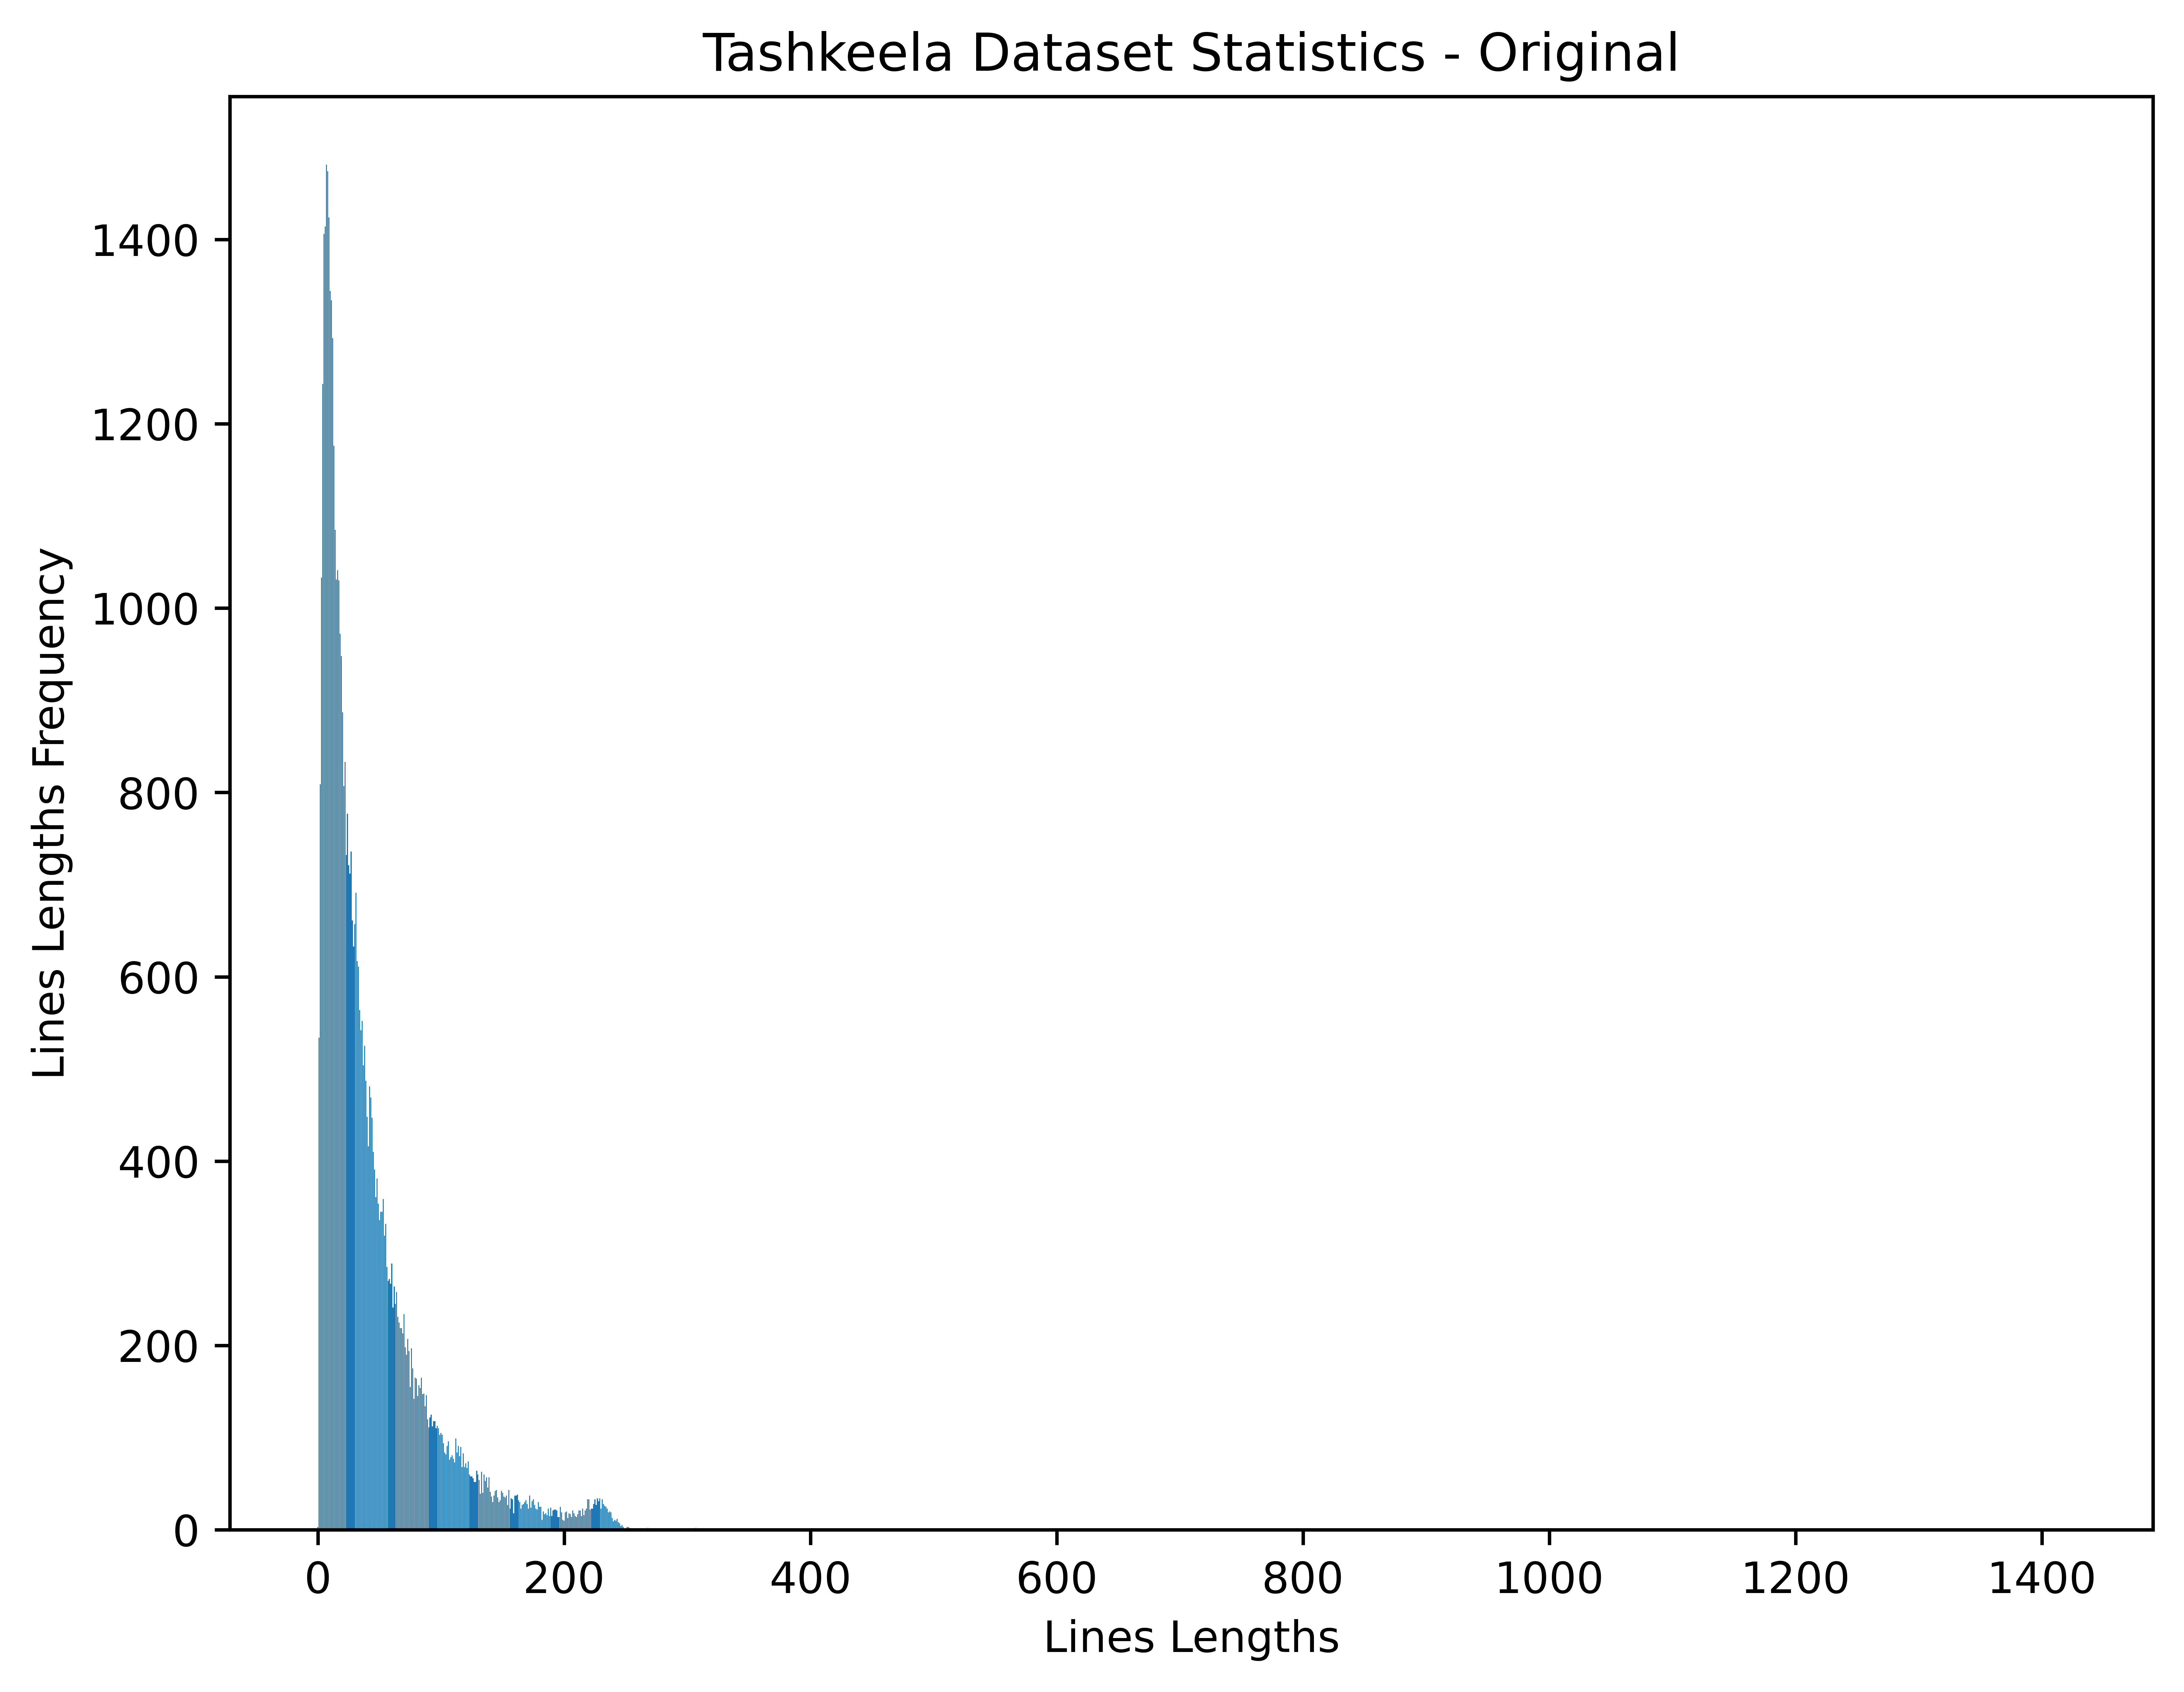

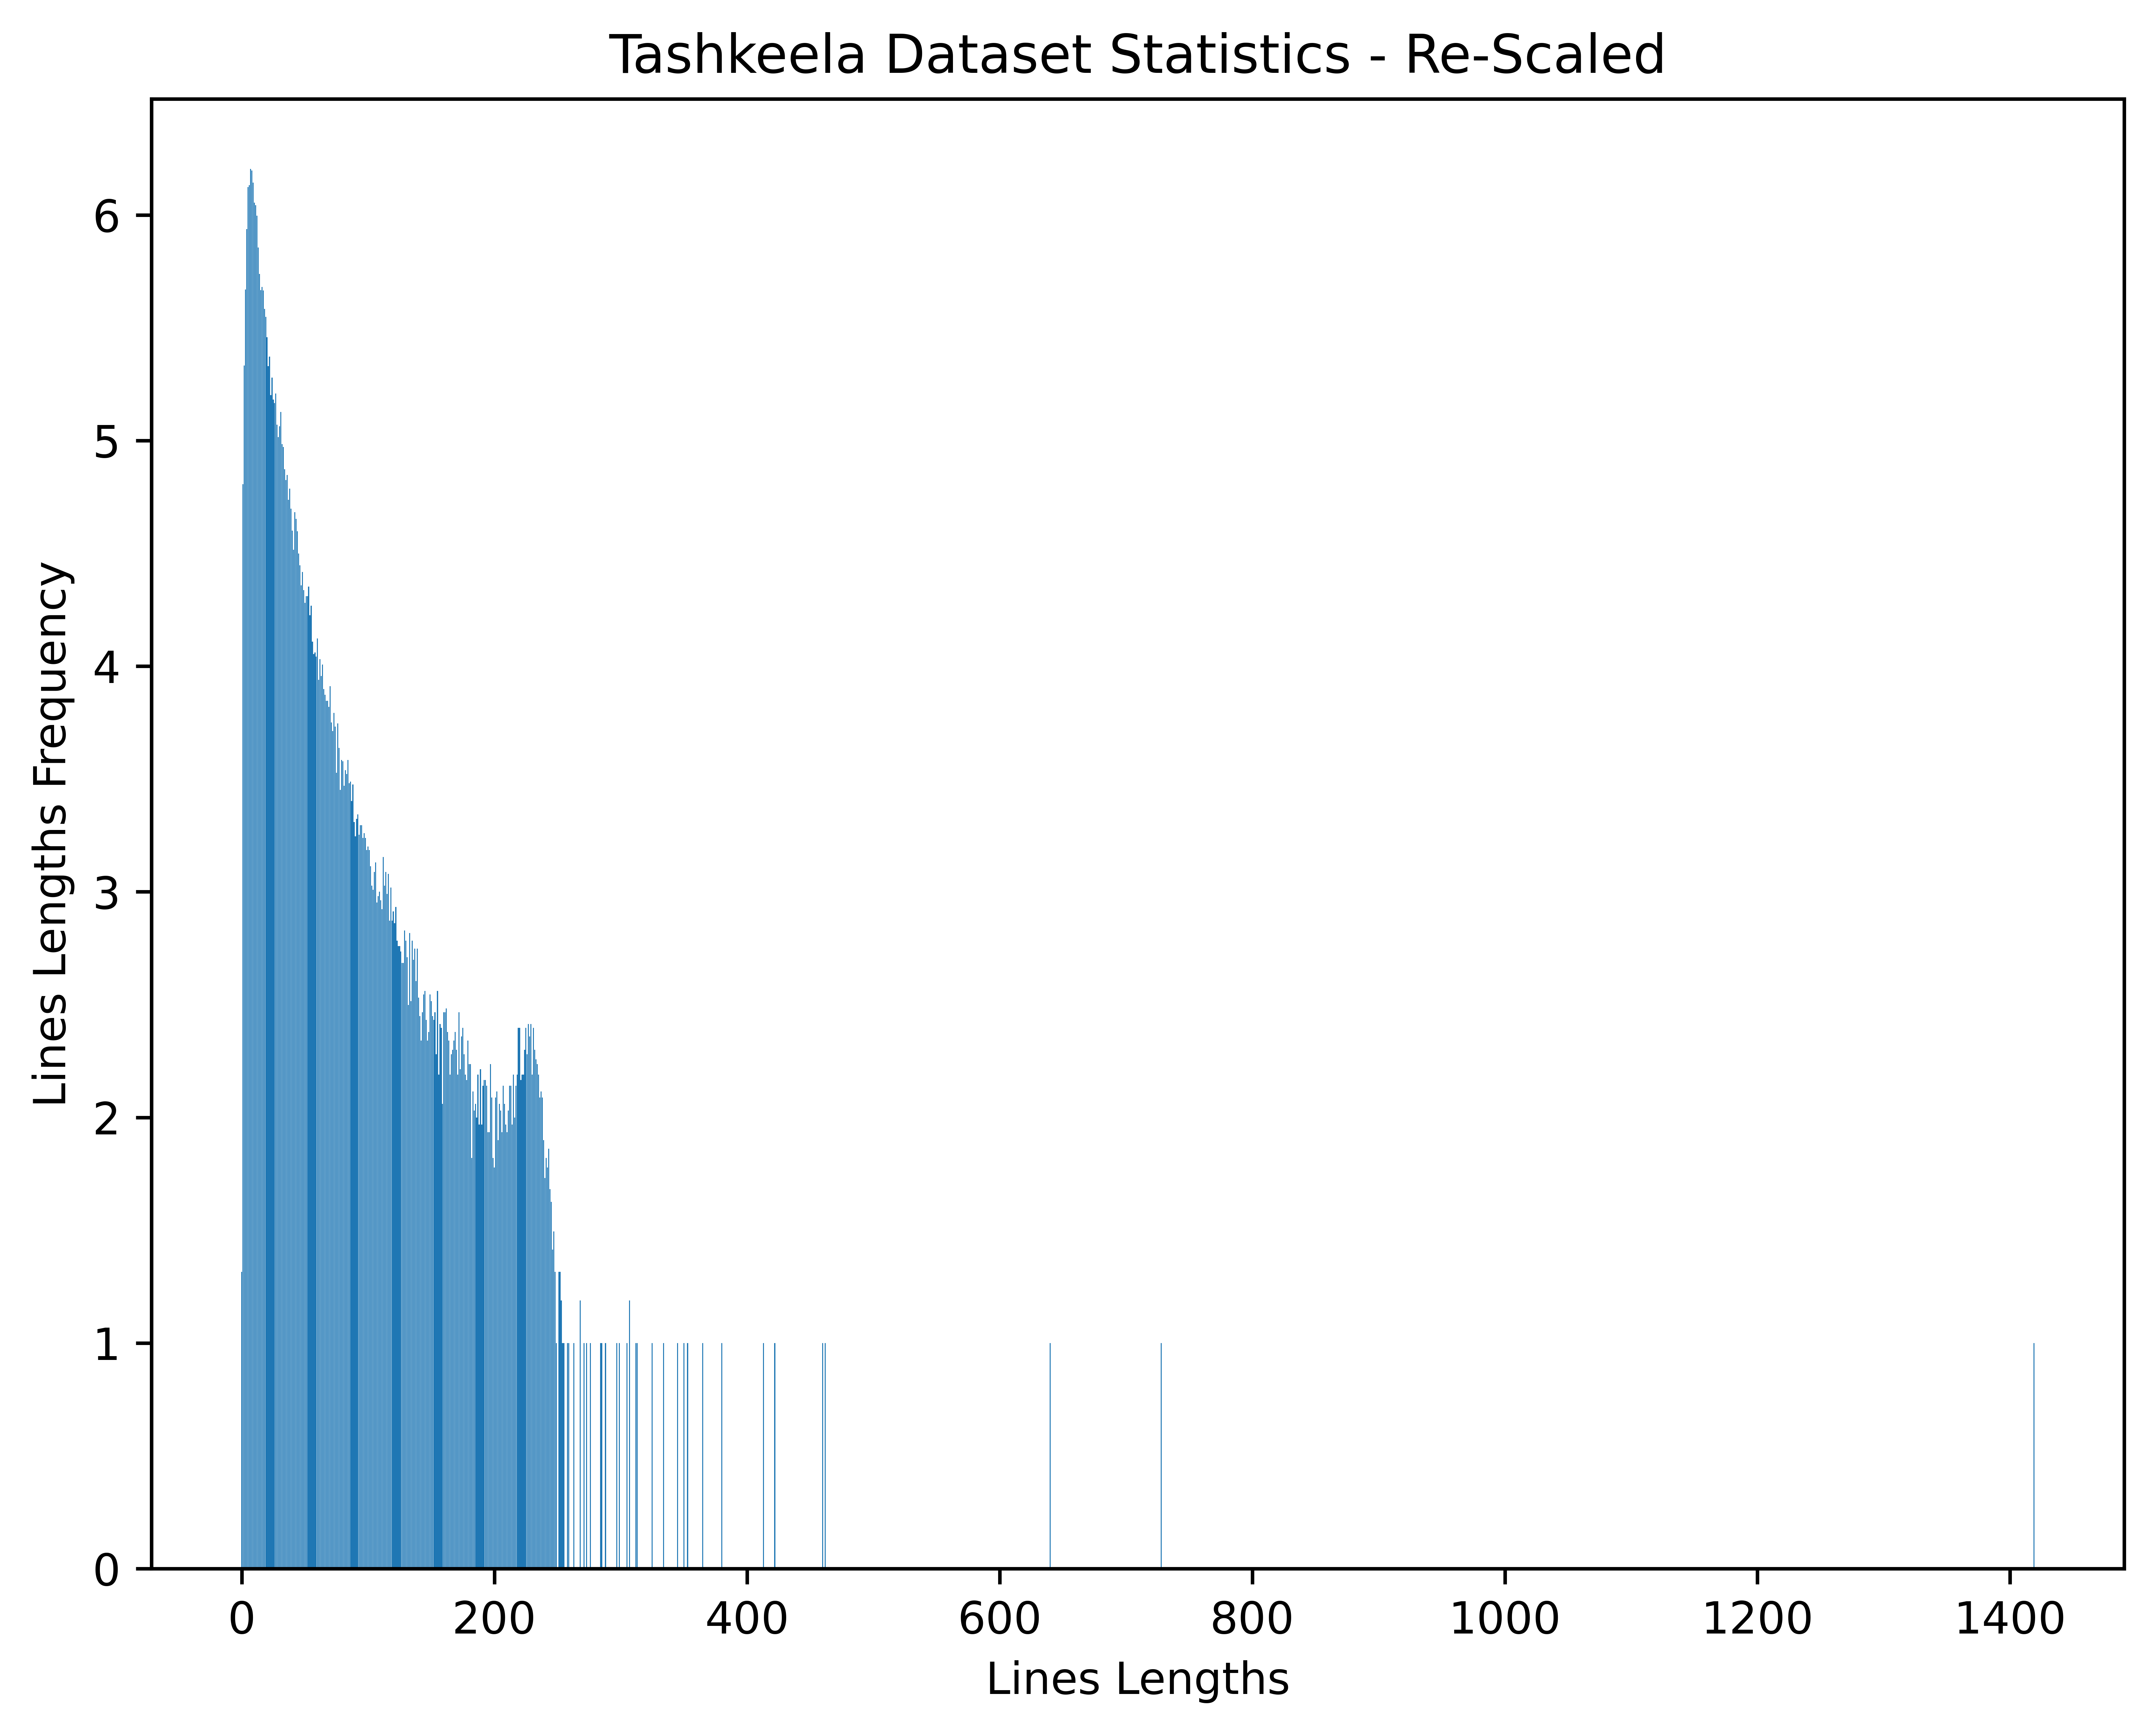

In [23]:
write_dataset_statistics('Tashkeela Dataset Statistics', statistics, line_lengths_fr)

In [26]:
# Load files
with open(diacritized_file, 'r', encoding='utf-8') as f:
    diacritized_lines = f.readlines()

with open(undiacritized_file, 'r', encoding='utf-8') as f:
    undiacritized_lines = f.readlines()

# Check if files are aligned
assert len(diacritized_lines) == len(undiacritized_lines), "Files are not aligned!"

# Combine into a DataFrame
import pandas as pd
data = pd.DataFrame({
    'diacritized': [line.strip() for line in diacritized_lines],
    'undiacritized': [line.strip() for line in undiacritized_lines]
})

# Save combined dataset (optional)
data.to_csv('combined_dataset.csv', index=False, encoding='utf-8')
print("Combined dataset created with shape:", data.shape)

# Load the CSV with UTF-8 encoding
file_path = "combined_dataset.csv"  # Replace with your file path
data = pd.read_csv(file_path, encoding='utf-8')

print(data.head())  # Display the first few rows to check Arabic text

Combined dataset created with shape: (50000, 2)
                                         diacritized  \
0  وَلَوْ جَمَعَ ثُمَّ عَلِمَ تَرْكَ رُكْنٍ مِنْ ...   
1  قَالَ أَبُو زَيْدٍ أَهْلُ تِهَامَةَ يُؤَنِّثُو...   
2  بِمَنْزِلَةِ أَهْلِ الذِّمَّةِ إذَا دَخَلُوا ق...   
3  الْمَسْأَلَةُ الْخَامِسَةُ قَوْله تَعَالَى : {...   
4  قَوْلُهُ ( وَاَلَّذِي لَا يَتَغَابَنُ النَّاسُ...   

                                       undiacritized  
0  ولو جمع ثم علم ترك ركن من الأولى بطلتا ويعيدهم...  
1  قال أبو زيد أهل تهامة يؤنثون العضد وبنو تميم ي...  
2  بمنزلة أهل الذمة إذا دخلوا قرية من قرى أهل الح...  
3  المسألة الخامسة قوله تعالى : { الذين يظاهرون }...  
4  قوله ( والذي لا يتغابن الناس في مثله ما لا يدخ...  


In [27]:
# Load the CSV with UTF-8 encoding
file_path = "combined_dataset.csv"  # Replace with your file path
data = pd.read_csv(file_path, encoding='utf-8')

print(data.head())  # Display the first few rows to check Arabic text

                                         diacritized  \
0  وَلَوْ جَمَعَ ثُمَّ عَلِمَ تَرْكَ رُكْنٍ مِنْ ...   
1  قَالَ أَبُو زَيْدٍ أَهْلُ تِهَامَةَ يُؤَنِّثُو...   
2  بِمَنْزِلَةِ أَهْلِ الذِّمَّةِ إذَا دَخَلُوا ق...   
3  الْمَسْأَلَةُ الْخَامِسَةُ قَوْله تَعَالَى : {...   
4  قَوْلُهُ ( وَاَلَّذِي لَا يَتَغَابَنُ النَّاسُ...   

                                       undiacritized  
0  ولو جمع ثم علم ترك ركن من الأولى بطلتا ويعيدهم...  
1  قال أبو زيد أهل تهامة يؤنثون العضد وبنو تميم ي...  
2  بمنزلة أهل الذمة إذا دخلوا قرية من قرى أهل الح...  
3  المسألة الخامسة قوله تعالى : { الذين يظاهرون }...  
4  قوله ( والذي لا يتغابن الناس في مثله ما لا يدخ...  


In [29]:
def count_each_dic(file_path):
    each = dict()

    with open( '/content/arabic-text-diacritization/helpers/constants/CLASSES_LIST.pickle', 'rb') as file:
        CLASSES_LIST = pkl.load(file)

    with open( '/content/arabic-text-diacritization/helpers/constants/ARABIC_LETTERS_LIST.pickle', 'rb') as file:
        ARABIC_LETTERS_LIST = pkl.load(file)

    with open( '/content/arabic-text-diacritization/helpers/constants/DIACRITICS_LIST.pickle', 'rb') as file:
        DIACRITICS_LIST = pkl.load(file)

    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    for line in lines:
        for idx, char in enumerate(line):
            if char in DIACRITICS_LIST:
                continue
            char_diac = ''
            if idx + 1 < len(line) and line[idx + 1] in DIACRITICS_LIST:
                char_diac = line[idx + 1]
                if idx + 2 < len(line) and line[idx + 2] in DIACRITICS_LIST and char_diac + line[idx + 2] in CLASSES_LIST:
                    char_diac += line[idx + 2]
                elif idx + 2 < len(line) and line[idx + 2] in DIACRITICS_LIST and line[idx + 2] + char_diac in CLASSES_LIST:
                    char_diac = line[idx + 2] + char_diac
            try:
                each[char_diac] += 1
            except:
                each[char_diac] = 1

    return each

# Run the function and print results
each = count_each_dic(file_path)

name = {
    '' : 'No Diacritic       ',
    'َ' : 'Fatha              ',
    'ً' : 'Fathatah           ',
    'ُ' : 'Damma              ',
    'ٌ' : 'Dammatan           ',
    'ِ' : 'Kasra              ',
    'ٍ' : 'Kasratan           ',
    'ْ' : 'Sukun              ',
    'ّ' : 'Shaddah            ',
    'َّ' : 'Shaddah + Fatha    ',
    'ًّ' : 'Shaddah + Fathatah ',
    'ُّ' : 'Shaddah + Damma    ',
    'ٌّ' : 'Shaddah + Dammatan ',
    'ِّ' : 'Shaddah + Kasra    ',
    'ٍّ' : 'Shaddah + Kasratan '
}

for key in name:
    print(name[key] + ':', each.get(key, 0))  # Use get to avoid KeyError if key doesn't exist

No Diacritic       : 15602931
Fatha              : 2932361
Fathatah           : 58104
Damma              : 811590
Dammatan           : 58115
Kasra              : 1264779
Kasratan           : 87730
Sukun              : 1229871
Shaddah            : 6240
Shaddah + Fatha    : 299828
Shaddah + Fathatah : 3492
Shaddah + Damma    : 43329
Shaddah + Dammatan : 4757
Shaddah + Kasra    : 63514
Shaddah + Kasratan : 5841


<ipython-input-30-a3004727f61f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=diacritic_names, y=diacritic_counts, palette='viridis')


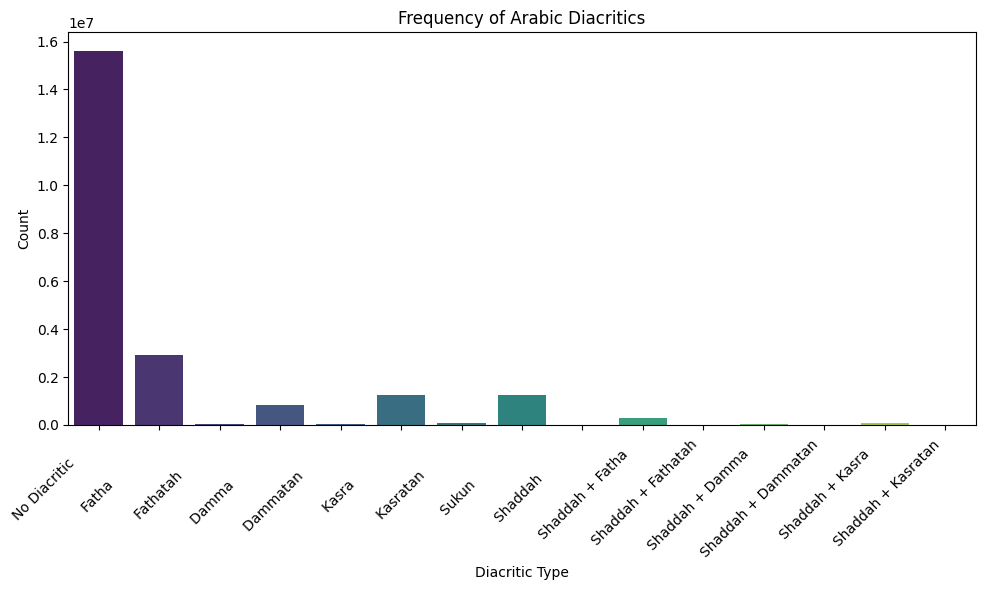

In [30]:
# Prepare the data for plotting
diacritic_names = [name[key] for key in name]
diacritic_counts = [each.get(key, 0) for key in name]

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=diacritic_names, y=diacritic_counts, palette='viridis')

# Rotate the labels on x-axis for better visibility
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Diacritic Type')
plt.ylabel('Count')
plt.title('Frequency of Arabic Diacritics')

# Display the plot
plt.tight_layout()
plt.show()

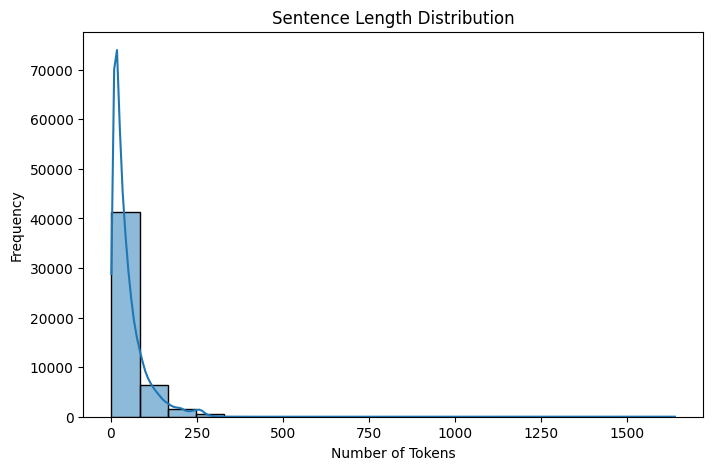

In [ ]:
## 3. Token Analysis
data['tokenized'] = data[diacritized_col].str.split()
token_lengths = data['tokenized'].apply(len)

# Sentence Length Distribution
plt.figure(figsize=(8, 5))
sns.histplot(token_lengths, bins=20, kde=True)
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

In [ ]:
## 5. Ambiguities
data['undiacritized'] = data[diacritized_col].apply(remove_diacritics)
ambiguous_words = data.groupby('undiacritized')[diacritized_col].nunique()
ambiguous_words = ambiguous_words[ambiguous_words > 1]
print("\nAmbiguous Words:", ambiguous_words)

## 6. Sample Inspection
print("\nSample Records:")
print(data.sample(5))


Ambiguous Words: undiacritized
أي ليس أحد يرثني                                              2
فأبشر بخزي في الحياة معجل ... وسربال قار خالدا في جهنم        2
واستيقنت بالذل لما شيعت ... ورجال أسلم وسطها وغفار            2
وجزم به في الوجيز ، والمنور ، ومنتخب الأزجي ، وغيرهم .        2
وعنه ينقض .                                                   2
يربون بالمعروف معروف من مضى ... وليس عليهم دون معروفهم قفل    2
Name: diacritized, dtype: int64

Sample Records:
                                             diacritized  \
49334  ( سُئِلَ ) عَنْ بَائِعِ أَمَةٍ بِشَرْطِ الْخِي...   
21716  ( 16 ) قَوْلُهُ : فَلَا يَصِحُّ مَعَ الْمُودَع...   
47808  ( وَالْمُحَرَّمُ النَّجِسُ ) / 97 تَقَدَّمَ قَ...   
1923   تَنْبِيهٌ : إنْ اخْتَلَفَ الْحَكَمَانِ فِي قَد...   
11771  ( قَوْلُهُ وَظَاهِرُهُ ) أَيْ كَلَامِ الشَّيْخ...   

                                           undiacritized  \
49334  ( سئل ) عن بائع أمة بشرط الخيار لهما قال كل أم...   
21716  ( 16 ) قوله : فلا يصح مع المودع بعد دعوى الهلاك

In [ ]:
file_path = "/content/arabic-text-diacritization/dataset/train.txt"  # Replace with the correct file path
with open(file_path, "r", encoding="utf-8") as file:
    text = file.read()

<ipython-input-68-fe4a1d7e1dbf>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=word_df, x='Frequency', y='Word', palette='viridis')


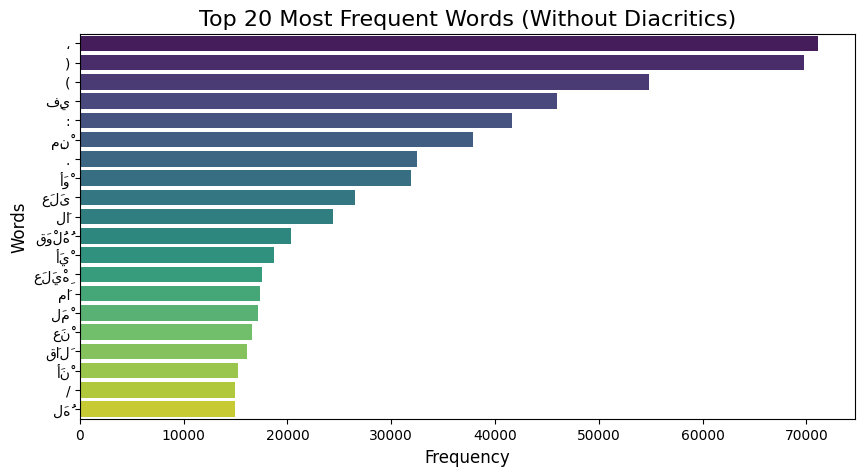

In [ ]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from bidi.algorithm import get_display  # For proper RTL display
import arabic_reshaper  # For reshaping Arabic words


# Tokenize the text into words
words = text.split()

# Count word frequencies
word_counts = Counter(words).most_common(20)
word_df = pd.DataFrame(word_counts, columns=['Word', 'Frequency'])

# Plot most frequent words
plt.figure(figsize=(10, 5))
sns.barplot(data=word_df, x='Frequency', y='Word', palette='viridis')
plt.title('Top 20 Most Frequent Words (Without Diacritics)', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.show()


<ipython-input-69-a3ae0d979dc5>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bigram_df, x='Frequency', y='Bigram', palette='viridis')


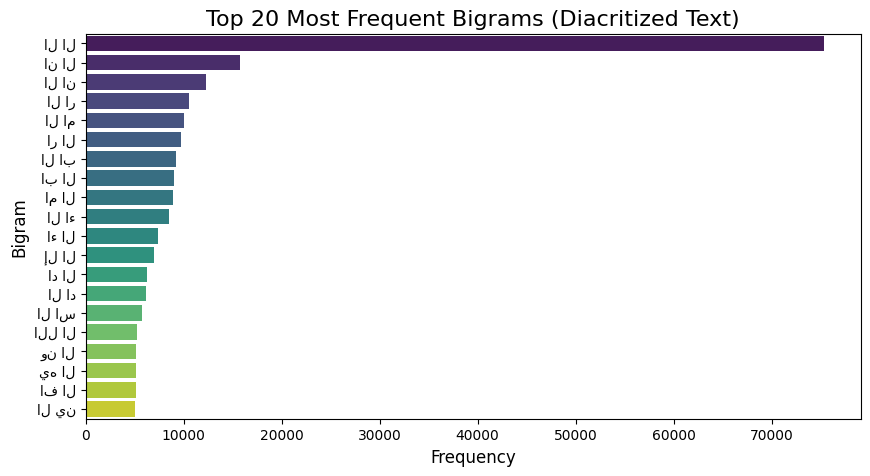

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize bigrams or trigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=20)  # Change to (3,3) for trigrams
bigrams = vectorizer.fit_transform([text])
bigram_counts = zip(vectorizer.get_feature_names_out(), bigrams.toarray().sum(axis=0))

# Create DataFrame for bigram frequency
bigram_df = pd.DataFrame(bigram_counts, columns=['Bigram', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Plot the most frequent bigrams
plt.figure(figsize=(10, 5))
sns.barplot(data=bigram_df, x='Frequency', y='Bigram', palette='viridis')
plt.title('Top 20 Most Frequent Bigrams (Diacritized Text)', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Bigram', fontsize=12)
plt.show()


<ipython-input-70-577615dc3102>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette='Blues_d')


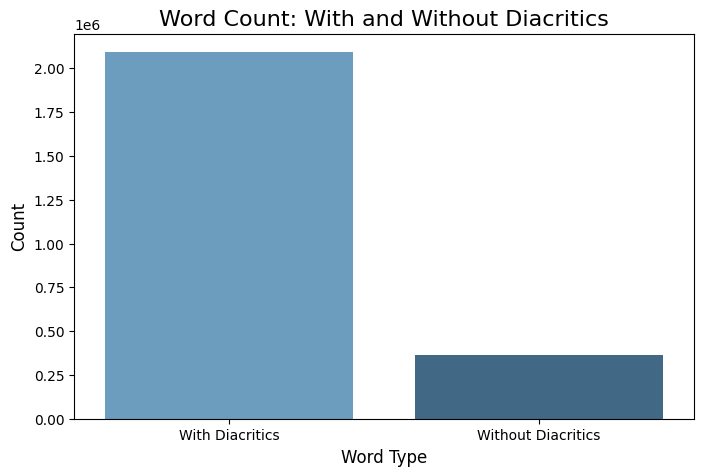

In [ ]:
# Count words with and without diacritics
words_with_diacritics = [word for word in text.split() if any(diacritic in word for diacritic in ['َ', 'ً', 'ُ', 'ٌ', 'ِ', 'ٍ', 'ْ', 'ّ', 'ٓ'])]
words_without_diacritics = [word for word in text.split() if not any(diacritic in word for diacritic in ['َ', 'ً', 'ُ', 'ٌ', 'ِ', 'ٍ', 'ْ', 'ّ', 'ٓ'])]

# Plot the count of words with vs. without diacritics
labels = ['With Diacritics', 'Without Diacritics']
counts = [len(words_with_diacritics), len(words_without_diacritics)]

plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=counts, palette='Blues_d')
plt.title('Word Count: With and Without Diacritics', fontsize=16)
plt.xlabel('Word Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


# **1- FFNN_Basic_Model**

In [ ]:
import time
import numpy as np
import pickle as pkl
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras

In [ ]:
import gc
import random
import argparse as args
import numpy as np
import pickle as pkl

random.seed(961)

CONSTANTS_PATH = '/content/shakkelha/helpers/constants'
CHARS_NUM = 50
CLASSES_NUM = 15

with open(CONSTANTS_PATH + '/ARABIC_LETTERS_LIST.pickle', 'rb') as file:
  ARABIC_LETTERS_LIST = pkl.load(file)

with open(CONSTANTS_PATH + '/DIACRITICS_LIST.pickle', 'rb') as file:
  DIACRITICS_LIST = pkl.load(file)

with open(CONSTANTS_PATH + '/FFNN_SMALL_CHARACTERS_MAPPING.pickle', 'rb') as file:
  CHARACTERS_MAPPING = pkl.load(file)

with open(CONSTANTS_PATH + '/FFNN_CLASSES_MAPPING.pickle', 'rb') as file:
  CLASSES_MAPPING = pkl.load(file)

def prepare_examples_from_lines(lines):
  X = list()
  Y = list()
  max_len = 0

  for line in lines:
    for idx, ch in enumerate(line):
      if ch not in ARABIC_LETTERS_LIST:
        continue

      y = [0] * CLASSES_NUM
      if idx + 1 < len(line) and line[idx + 1] in DIACRITICS_LIST:
        ch_diac = line[idx + 1]
        if idx + 2 < len(line) and line[idx + 2] in DIACRITICS_LIST and ch_diac + line[idx + 2] in CLASSES_MAPPING:
          ch_diac += line[idx + 2]
        y[CLASSES_MAPPING[ch_diac]] = 1
      else:
        y[0] = 1

      before = list()
      after = list()

      for idxb in range(idx - 1, -1, -1):
        if len(before) >= CHARS_NUM:
          break
        if line[idxb] not in DIACRITICS_LIST:
          before.append(line[idxb])
      before = before[::-1]
      before_need = CHARS_NUM - len(before)

      for idxa in range(idx, len(line)):
        if len(after) >= CHARS_NUM:
          break
        if line[idxa] not in DIACRITICS_LIST:
          after.append(line[idxa])
      after_need = CHARS_NUM - len(after)

      x = list()
      x.append(before_need)
      x.extend([CHARACTERS_MAPPING[ch] if ch in CHARACTERS_MAPPING else 0 for ch in before])
      x.extend([CHARACTERS_MAPPING[ch] if ch in CHARACTERS_MAPPING else 0 for ch in after])
      x.append(after_need)

      X.append(x)
      Y.append(y)
      max_len = max(max_len, len(x))
  for i in range(len(X)):
    X[i] = X[i] + [0] * (max_len - len(X[i]))
  X = np.asarray(X)
  Y = np.asarray(Y)

  return X, Y


def prepare_data(train_file, val_file, test_file):
  train_data = list()
  with open(train_file, 'r') as file:
      train_data = file.readlines()
  print('Total number of lines (Training):', len(train_data))

  val_data = list()
  with open(val_file, 'r') as file:
      val_data = file.readlines()
  print('Total number of lines (Validation):', len(val_data))

  test_data = list()
  with open(test_file, 'r') as file:
      test_data = file.readlines()
  print('Total number of lines (Testing):', len(test_data))

  X_train, Y_train = prepare_examples_from_lines(train_data)
  with open('X_train.pickle', 'wb') as file:
    pkl.dump(X_train, file)
  with open('Y_train.pickle', 'wb') as file:
    pkl.dump(Y_train, file)
  X_train = None
  Y_train = None
  gc.collect()

  X_val, Y_val = prepare_examples_from_lines(val_data)
  with open('X_val.pickle', 'wb') as file:
    pkl.dump(X_val, file)
  with open('Y_val.pickle', 'wb') as file:
    pkl.dump(Y_val, file)
  X_val = None
  Y_val = None
  gc.collect()

  X_test, Y_test = prepare_examples_from_lines(test_data)
  with open('X_test.pickle', 'wb') as file:
    pkl.dump(X_test, file)
  with open('Y_test.pickle', 'wb') as file:
    pkl.dump(Y_test, file)
  X_test = None
  Y_test = None
  gc.collect()


In [ ]:
import random

# Load the text file
with open('/content/arabic-text-diacritization/dataset/processed/train.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Calculate 2% of the total lines
subset_size = int(len(lines) * 0.2)

# Randomly sample 2% of the lines
subset = random.sample(lines, subset_size)

# Save the subset to a new file
with open('subset_train.txt', 'w', encoding='utf-8') as file:
    file.writelines(subset)



# Load the text file
with open('/content/arabic-text-diacritization/dataset/processed/val.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Calculate 2% of the total lines
subset_size = int(len(lines) * 0.2)

# Randomly sample 2% of the lines
subset = random.sample(lines, subset_size)

# Save the subset to a new file
with open('subset_val.txt', 'w', encoding='utf-8') as file:
    file.writelines(subset)




# Load the text file
with open('/content/arabic-text-diacritization/dataset/processed/test.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Calculate 2% of the total lines
subset_size = int(len(lines) * 0.2)

# Randomly sample 2% of the lines
subset = random.sample(lines, subset_size)

# Save the subset to a new file
with open('subset_test.txt', 'w', encoding='utf-8') as file:
    file.writelines(subset)


In [ ]:
# Define file paths
train_file = 'subset_train.txt'
val_file = 'subset_val.txt'
test_file = 'subset_test.txt'

# Call the function to process data
prepare_data(train_file, val_file, test_file)


Total number of lines (Training): 10000
Total number of lines (Validation): 500
Total number of lines (Testing): 500


In [ ]:
CHARS_NUM = 50
CLASSES_NUM = 15

In [ ]:
X_train = None
Y_train = None
with open('/content/X_train.pickle', 'rb') as X_train_file, \
         open('/content/Y_train.pickle', 'rb') as Y_train_file:
    X_train = pkl.load(X_train_file)
    Y_train = pkl.load(Y_train_file)
print('Training examples:', len(X_train))

X_val = None
Y_val = None
with open('/content/X_val.pickle', 'rb') as X_val_file, \
         open('/content/Y_val.pickle', 'rb') as Y_val_file:
    X_val = pkl.load(X_val_file)
    Y_val = pkl.load(Y_val_file)
print('Validation examples:', len(X_val))

X_test = None
Y_test = None
with open('/content/X_test.pickle', 'rb') as X_test_file, \
         open('/content/Y_test.pickle', 'rb') as Y_test_file:
    X_test = pkl.load(X_test_file)
    Y_test = pkl.load(Y_test_file)
print('Testing examples:', len(X_test))

Training examples: 1658666
Validation examples: 80340
Testing examples: 86737


In [ ]:
def create_dense_layer(neurons):
    return keras.layers.Dense(neurons,
                              activation=tf.nn.relu,
                              kernel_initializer=keras.initializers.glorot_normal(seed=961))

def create_model():
    model = keras.models.Sequential([
        keras.layers.Dense(128,
                           input_shape=(150,),
                           activation=tf.nn.relu,
                           kernel_initializer=keras.initializers.glorot_normal(seed=961)),
        create_dense_layer(500),
        create_dense_layer(500),
        create_dense_layer(450),
        create_dense_layer(400),
        create_dense_layer(400),
        create_dense_layer(350),
        create_dense_layer(300),
        create_dense_layer(300),
        create_dense_layer(250),
        create_dense_layer(200),
        create_dense_layer(200),
        create_dense_layer(150),
        create_dense_layer(100),
        create_dense_layer(100),
        create_dense_layer(50),
        create_dense_layer(25),
        keras.layers.Dense(CLASSES_NUM,
                           activation=tf.nn.softmax,
                           kernel_initializer=keras.initializers.glorot_normal(seed=961))
    ])

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
                  metrics=['accuracy'])

    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               19328     
                                                                 
 dense_1 (Dense)             (None, 500)               64500     
                                                                 
 dense_2 (Dense)             (None, 500)               250500    
                                                                 
 dense_3 (Dense)             (None, 450)               225450    
                                                                 
 dense_4 (Dense)             (None, 400)               180400    
                                                                 
 dense_5 (Dense)             (None, 400)               160400    
                                                                 
 dense_6 (Dense)             (None, 350)               1

In [ ]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, X, Y, batch_size, max_seq_len):  # Add max_seq_len as an argument
        self.X, self.Y = X, Y
        self.batch_size = batch_size
        self.max_seq_len = max_seq_len  # Store max_seq_len

    def __len__(self):
        return int(np.ceil(len(self.X) / float(self.batch_size)))

    def __getitem__(self, idx):
        X_batch = np.asarray(self.X[idx * self.batch_size:(idx + 1) * self.batch_size])
        Y_batch = np.asarray(self.Y[idx * self.batch_size:(idx + 1) * self.batch_size])

        X_tmp = list()
        for x in X_batch:
            before_need = x[0]
            after_need = x[-1]
            x_new = list()
            x_new.extend([1] * before_need)
            x_new.extend(x[1:-1])
            x_new.extend([1] * after_need)

            # Pad x_new to max_seq_len
            x_new = np.pad(x_new, (0, self.max_seq_len - len(x_new)), 'constant')

            X_tmp.append(np.asarray(x_new))

        X_batch = np.asarray(X_tmp)
        Y_batch = np.asarray(Y_batch)

        return X_batch, Y_batch # Added the return statement

In [ ]:
def calculate_max_seq_len(X):
    """Calculates the maximum sequence length in the data.

    Args:
        X: The input data containing sequences.

    Returns:
        The maximum sequence length.
    """
    max_len = 0
    for x in X:
        # Calculate the length of the padded sequence
        current_len = x[0] + len(x[1:-1]) + x[-1]
        max_len = max(max_len, current_len)
    return max_len

# Assuming X_train is your training data
max_seq_len = calculate_max_seq_len(X_train)
print(f"Maximum sequence length: {max_seq_len}")

Maximum sequence length: 150


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


    # Add EarlyStopping
early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
        patience=3,          # Number of epochs with no improvement before stopping
        restore_best_weights=True,  # Restore weights from the best epoch
        verbose=1            # Print stopping message
    )

In [ ]:
def fit_model(model, epochs, batch_size, max_seq_len):
    checkpoint_path = 'checkpoints/epoch{epoch:03d}.keras'
    cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=0)

    # Pass max_seq_len to the DataGenerator
    training_generator = DataGenerator(X_train, Y_train, batch_size, max_seq_len)
    val_generator = DataGenerator(X_val, Y_val, batch_size, max_seq_len)

    # Fit the model using the generators
    history_ffnn = model.fit(training_generator,
              validation_data=val_generator,
              epochs=epochs,
              callbacks=[cp_callback, early_stopping])
    return history_ffnn


In [ ]:
start_time = time.time()
history_ffnn = fit_model(model, 50, 512,max_seq_len)
end_time = time.time()
print("--- %s seconds ---" % round(end_time - start_time, 2))

Epoch 1/50
3240/3240 [==============================] - 94s 29ms/step - loss: 1.3536 - accuracy: 0.5010 - val_loss: 1.3540 - val_accuracy: 0.4931
Epoch 2/50
3240/3240 [==============================] - 94s 29ms/step - loss: 1.2202 - accuracy: 0.5519 - val_loss: 1.1676 - val_accuracy: 0.5740
Epoch 3/50
3240/3240 [==============================] - 94s 29ms/step - loss: 1.1392 - accuracy: 0.5844 - val_loss: 1.0629 - val_accuracy: 0.6162
Epoch 4/50
3240/3240 [==============================] - 93s 29ms/step - loss: 1.0785 - accuracy: 0.6085 - val_loss: 1.0267 - val_accuracy: 0.6288
Epoch 5/50
3240/3240 [==============================] - 94s 29ms/step - loss: 1.0297 - accuracy: 0.6275 - val_loss: 0.9549 - val_accuracy: 0.6528
Epoch 6/50
3240/3240 [==============================] - 94s 29ms/step - loss: 0.9888 - accuracy: 0.6433 - val_loss: 0.9756 - val_accuracy: 0.6444
Epoch 7/50
3240/3240 [==============================] - 94s 29ms/step - loss: 0.9530 - accuracy: 0.6572 - val_loss: 0.9304 -

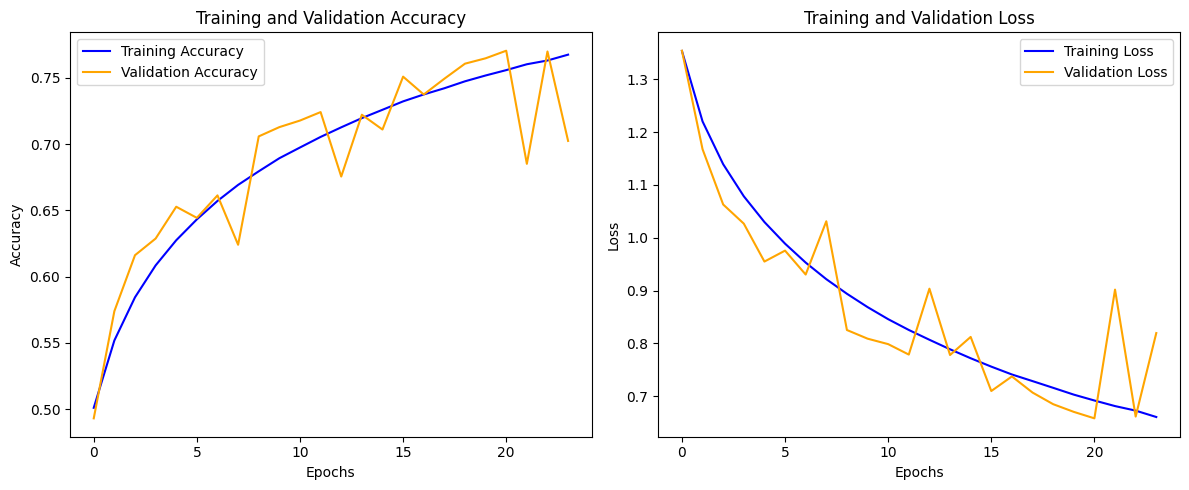

In [ ]:
import matplotlib.pyplot as plt

# Assuming history_ffnn contains the training history
history = history_ffnn.history

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy', color='b')
plt.plot(history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss', color='b')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


# Testing

In [ ]:
test_generator = DataGenerator(X_test, Y_test,  len(X_test),max_seq_len)

XY_test = list()
for batch in range(len(test_generator)):
    XY_test.append(test_generator[batch])
X, Y = zip(*XY_test)

X = np.asarray(X)
Y = np.asarray(Y)

X = np.squeeze(X)
Y = np.squeeze(Y)

In [ ]:
loss, acc = model.evaluate(X, Y, batch_size=512)
print('Accuracy: %s%%' % round(acc * 100, 2))
print('Loss: %s' % round(loss, 2))

170/170 [==============================] - 1s 8ms/step - loss: 0.6653 - accuracy: 0.7674
Accuracy: 76.74%
Loss: 0.67


# Predicting

In [ ]:
def predict(line):
    equal = 0
    not_equal = 0
    output = ''
    REV_CLASSES_MAPPING = {v: k for k, v in CLASSES_MAPPING.items()}

    for idx, ch in enumerate(line):
        if ch in DIACRITICS_LIST:
            continue

        output += ch

        if ch not in ARABIC_LETTERS_LIST:
            continue

        y_true = [0] * CLASSES_NUM
        if idx + 1 < len(line) and line[idx + 1] in DIACRITICS_LIST:
            ch_diac = line[idx + 1]
            if idx + 2 < len(line) and line[idx + 2] in DIACRITICS_LIST and ch_diac + line[idx + 2] in CLASSES_MAPPING:
                ch_diac += line[idx + 2]
            y_true[CLASSES_MAPPING[ch_diac]] = 1
        else:
            y_true[0] = 1
        y_true = np.asarray(y_true).reshape(1, -1)

        before = list()
        after = list()

        for idxb in range(idx - 1, -1, -1):
            if len(before) >= CHARS_NUM:
                break
            if line[idxb] not in DIACRITICS_LIST:
                before.append(line[idxb])
        before = before[::-1]
        before_need = CHARS_NUM - len(before)

        for idxa in range(idx, len(line)):
            if len(after) >= CHARS_NUM:
                break
            if line[idxa] not in DIACRITICS_LIST:
                after.append(line[idxa])
        after_need = CHARS_NUM - len(after)

        x = list()
        x.extend([1] * before_need)
        x.extend([CHARACTERS_MAPPING[ch] for ch in before])
        x.extend([CHARACTERS_MAPPING[ch] for ch in after])
        x.extend([1] * after_need)

        # Check the length of x and pad if necessary
        if len(x) < model.input_shape[1]:
            x.extend([0] * (model.input_shape[1] - len(x)))
        elif len(x) > model.input_shape[1]:
            x = x[:model.input_shape[1]] # Truncate if longer

        x = np.asarray(x)

        # Reshape x to match the expected input shape of the model
        x = np.asarray(x).reshape(1, model.input_shape[1])  # Assuming model.input_shape[1] is 150

        y_pred = model.predict(x)

        y_true_mx = np.argmax(y_true)
        y_pred_mx = np.argmax(y_pred)

        equal += (y_true_mx == y_pred_mx)
        not_equal += (y_true_mx != y_pred_mx)

        if y_pred_mx == 0:
            continue

        output += REV_CLASSES_MAPPING[y_pred_mx]
    return output, equal, not_equal

In [ ]:
text = 'اللَّهُمَّ عَلِّمْنَا مَا يَنْفَعُنَا وَإِنْفَعْنَا بِمَا عَلَّمْتَنَا إِنَّكَ أَنْتَ العَلِيمُ الحَكِيمُ'
prediction = predict(text)
print(prediction[0], prediction[1], prediction[2], prediction[1] / (prediction[1] + prediction[2]) * 100, sep='\n')

1/1 [==============================] - 0s 24ms/step
الْلَّهُمْ عَلِمْنَا مَا يَنْفَعُنَا وَإَنْفُعَنَا بِمَا عَلْمَتُنَا إَنْكَ أَنَتِ الْعَلِيمِ الْحَكُيمِ
33
19
63.46153846153846


# **2- FFNN_Embeddings_Model**

In [ ]:
# Define file paths
train_file = 'subset_train.txt'
val_file = 'subset_val.txt'
test_file = 'subset_test.txt'

# Call the function to process data
prepare_data(train_file, val_file, test_file)


Total number of lines (Training): 10000
Total number of lines (Validation): 500
Total number of lines (Testing): 500


In [ ]:
CHARS_NUM = 50
CLASSES_NUM = 15

In [ ]:
X_train = None
Y_train = None
with open('/content/X_train.pickle', 'rb') as X_train_file, \
         open('/content/Y_train.pickle', 'rb') as Y_train_file:
    X_train = pkl.load(X_train_file)
    Y_train = pkl.load(Y_train_file)
print('Training examples:', len(X_train))

X_val = None
Y_val = None
with open('/content/X_val.pickle', 'rb') as X_val_file, \
         open('/content/Y_val.pickle', 'rb') as Y_val_file:
    X_val = pkl.load(X_val_file)
    Y_val = pkl.load(Y_val_file)
print('Validation examples:', len(X_val))

X_test = None
Y_test = None
with open('/content/X_test.pickle', 'rb') as X_test_file, \
         open('/content/Y_test.pickle', 'rb') as Y_test_file:
    X_test = pkl.load(X_test_file)
    Y_test = pkl.load(Y_test_file)
print('Testing examples:', len(X_test))

Training examples: 1658666
Validation examples: 80340
Testing examples: 86737


In [ ]:
def create_dense_layer(neurons):
    return keras.layers.Dense(neurons,
                              activation=tf.nn.relu,
                              kernel_initializer=keras.initializers.glorot_normal(seed=961))

def create_model(dropout_factor):
    model = tf.keras.models.Sequential([
        keras.layers.Embedding(input_dim=83,
                               output_dim=25,
                               input_length=2 * CHARS_NUM,  # Set input length to 2 * CHARS_NUM
                               embeddings_initializer=keras.initializers.glorot_normal(seed=961)),
        keras.layers.Flatten(),
        keras.layers.Dropout(dropout_factor),
        create_dense_layer(250),
        create_dense_layer(200),
        create_dense_layer(150),
        create_dense_layer(100),
        create_dense_layer(50),
        keras.layers.Dense(CLASSES_NUM,
                           activation=tf.nn.softmax,
                           kernel_initializer=keras.initializers.glorot_normal(seed=961))
    ])

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])

    return model


In [ ]:
# After creating the model
model = create_model(0.025)

# Build the model with an input shape of (batch_size, input_length)
model.build(input_shape=(512, 2 * CHARS_NUM))

# Print model summary to check the output
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (512, 100, 25)              │           2,075 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (512, 2500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (512, 2500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (512, 250)                  │         625,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (512, 200)                  │          50,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (512, 150)                  │          30,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (512, 100)                  │          15,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (512, 50)                   │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (512, 15)                   │             765 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 728,590 (2.78 MB)

 Trainable params: 728,590 (2.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, X, Y, batch_size, **kwargs):
        super().__init__(**kwargs)  # Properly call the parent class constructor
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.max_len = 2 * CHARS_NUM  # Ensure it's consistent with your model's input length

    def __len__(self):
        return int(np.ceil(len(self.X) / float(self.batch_size)))

    def __getitem__(self, idx):
        X_batch = np.asarray(self.X[idx * self.batch_size:(idx + 1) * self.batch_size])
        Y_batch = np.asarray(self.Y[idx * self.batch_size:(idx + 1) * self.batch_size])

        X_tmp = []
        for x in X_batch:
            before_need = x[0]
            after_need = x[-1]
            x_new = []
            x_new.extend([1] * before_need)
            x_new.extend(x[1:-1])
            x_new.extend([1] * after_need)

            x_new = x_new[:self.max_len]  # Truncate if longer than max_len
            x_new = np.pad(x_new, (0, self.max_len - len(x_new)), 'constant', constant_values=0)  # Pad with zeros
            X_tmp.append(x_new)

        X_batch = np.asarray(X_tmp)
        return X_batch, Y_batch


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


    # Add EarlyStopping
early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
        patience=3,          # Number of epochs with no improvement before stopping
        restore_best_weights=True,  # Restore weights from the best epoch
        verbose=1            # Print stopping message
    )

In [ ]:
def fit_model(model, epochs, batch_size):
    checkpoint_path = 'checkpoints/epoch{epoch:02d}.keras'
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=0)

    training_generator = DataGenerator(X_train, Y_train, batch_size)
    val_generator = DataGenerator(X_val, Y_val, batch_size)

    emb_history = model.fit(x=training_generator,  # Pass training generator to 'x'
              validation_data=val_generator,
              epochs=epochs,
              callbacks=[cp_callback, early_stopping])
    return emb_history

In [ ]:
start_time = time.time()
emb_history = fit_model(model, 50, 512)
end_time = time.time()
print("--- %s seconds ---" % round(end_time - start_time, 2))

Epoch 1/50
3240/3240 ━━━━━━━━━━━━━━━━━━━━ 162s 47ms/step - accuracy: 0.7122 - loss: 0.8200 - val_accuracy: 0.8549 - val_loss: 0.4035
Epoch 2/50
3240/3240 ━━━━━━━━━━━━━━━━━━━━ 150s 46ms/step - accuracy: 0.8688 - loss: 0.3667 - val_accuracy: 0.8794 - val_loss: 0.3347
Epoch 3/50
3240/3240 ━━━━━━━━━━━━━━━━━━━━ 154s 47ms/step - accuracy: 0.8969 - loss: 0.2896 - val_accuracy: 0.8891 - val_loss: 0.3144
Epoch 4/50
3240/3240 ━━━━━━━━━━━━━━━━━━━━ 198s 46ms/step - accuracy: 0.9119 - loss: 0.2463 - val_accuracy: 0.8927 - val_loss: 0.3058
Epoch 5/50
3240/3240 ━━━━━━━━━━━━━━━━━━━━ 201s 46ms/step - accuracy: 0.9222 - loss: 0.2178 - val_accuracy: 0.8950 - val_loss: 0.3029
Epoch 6/50
3240/3240 ━━━━━━━━━━━━━━━━━━━━ 207s 47ms/step - accuracy: 0.9304 - loss: 0.1952 - val_accuracy: 0.8962 - val_loss: 0.2987
Epoch 7/50
3240/3240 ━━━━━━━━━━━━━━━━━━━━ 148s 46ms/step - accuracy: 0.9362 - loss: 0.1785 - val_accuracy: 0.8985 - val_loss: 0.3051
Epoch 8/50
3240/3240 ━━━━━━━━━━━━━━━━━━━━ 150s 46ms/step - accuracy: 

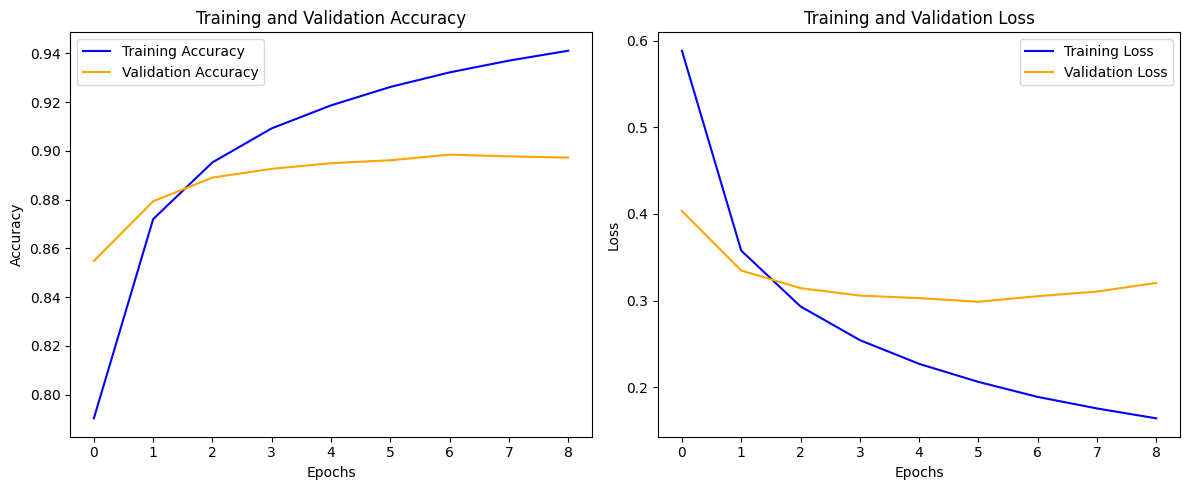

In [ ]:
import matplotlib.pyplot as plt

# Assuming history_ffnn contains the training history
history = emb_history.history

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy', color='b')
plt.plot(history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss', color='b')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Testing

In [ ]:
CHARS_NUM = 50
CLASSES_NUM = 15

with open( '/content/shakkelha/helpers/constants/ARABIC_LETTERS_LIST.pickle', 'rb') as file:
    ARABIC_LETTERS_LIST = pkl.load(file)

with open( '/content/shakkelha/helpers/constants/DIACRITICS_LIST.pickle', 'rb') as file:
    DIACRITICS_LIST = pkl.load(file)

with open( '/content/shakkelha/helpers/constants/FFNN_SMALL_CHARACTERS_MAPPING.pickle', 'rb') as file:
    CHARACTERS_MAPPING = pkl.load(file)

with open( '/content/shakkelha/helpers/constants/FFNN_CLASSES_MAPPING.pickle', 'rb') as file:
    CLASSES_MAPPING = pkl.load(file)

with open( '/content/shakkelha/helpers/constants/FFNN_REV_CLASSES_MAPPING.pickle', 'rb') as file:
    REV_CLASSES_MAPPING = pkl.load(file)

In [ ]:
X_test = None
Y_test = None
with open('/content/X_test.pickle', 'rb') as X_test_file, \
         open( '/content/Y_test.pickle', 'rb') as Y_test_file:
    X_test = pkl.load(X_test_file)
    Y_test = pkl.load(Y_test_file)
print('Testing examples:', len(X_test))

Testing examples: 86737


In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, X, Y, batch_size, **kwargs):
        super().__init__(**kwargs)  # Properly call the parent class constructor
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.max_len = 2 * CHARS_NUM  # Ensure it's consistent with your model's input length

    def __len__(self):
        return int(np.ceil(len(self.X) / float(self.batch_size)))

    def __getitem__(self, idx):
        X_batch = np.asarray(self.X[idx * self.batch_size:(idx + 1) * self.batch_size])
        Y_batch = np.asarray(self.Y[idx * self.batch_size:(idx + 1) * self.batch_size])

        X_tmp = []
        for x in X_batch:
            before_need = x[0]
            after_need = x[-1]
            x_new = []
            x_new.extend([1] * before_need)
            x_new.extend(x[1:-1])
            x_new.extend([1] * after_need)

            x_new = x_new[:self.max_len]  # Truncate if longer than max_len
            x_new = np.pad(x_new, (0, self.max_len - len(x_new)), 'constant', constant_values=0)  # Pad with zeros
            X_tmp.append(x_new)

        X_batch = np.asarray(X_tmp)
        return X_batch, Y_batch


In [ ]:
test_generator = DataGenerator(X_test, Y_test, batch_size=512)  # Use the batch size your model was trained on.

# Evaluate the model using the generator
loss, acc = model.evaluate(test_generator)

print('Accuracy: %s%%' % round(acc * 100, 2))
print('Loss: %s' % round(loss, 2))

170/170 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.8970 - loss: 0.2974
Accuracy: 89.61%
Loss: 0.3


# Predicting

In [ ]:
def predict(line):
    equal = 0
    not_equal = 0
    output = ''

    for idx, ch in enumerate(line):
        if ch in DIACRITICS_LIST:
            continue

        output += ch

        if ch not in ARABIC_LETTERS_LIST:
            continue

        y_true = [0] * CLASSES_NUM
        if idx + 1 < len(line) and line[idx + 1] in DIACRITICS_LIST:
            ch_diac = line[idx + 1]
            if idx + 2 < len(line) and line[idx + 2] in DIACRITICS_LIST and ch_diac + line[idx + 2] in CLASSES_MAPPING:
                ch_diac += line[idx + 2]
            y_true[CLASSES_MAPPING[ch_diac]] = 1
        else:
            y_true[0] = 1
        y_true = np.asarray(y_true).reshape(1, -1)

        before = list()
        after = list()

        for idxb in range(idx - 1, -1, -1):
            if len(before) >= CHARS_NUM:
                break
            if line[idxb] not in DIACRITICS_LIST:
                before.append(line[idxb])
        before = before[::-1]
        before_need = CHARS_NUM - len(before)

        for idxa in range(idx, len(line)):
            if len(after) >= CHARS_NUM:
                break
            if line[idxa] not in DIACRITICS_LIST:
                after.append(line[idxa])
        after_need = CHARS_NUM - len(after)

        x = list()
        x.extend([1] * before_need)
        x.extend([CHARACTERS_MAPPING[ch] for ch in before])
        x.extend([CHARACTERS_MAPPING[ch] for ch in after])
        x.extend([1] * after_need)

        # Check the length of x and pad if necessary
        if len(x) < model.input_shape[1]:
            x.extend([0] * (model.input_shape[1] - len(x)))
        elif len(x) > model.input_shape[1]:
            x = x[:model.input_shape[1]] # Truncate if longer

        x = np.asarray(x)

        # Reshape x to match the expected input shape of the model
        x = np.asarray(x).reshape(1, model.input_shape[1])  # Assuming model.input_shape[1] is 150

        y_pred = model.predict(x)

        y_true_mx = np.argmax(y_true)
        y_pred_mx = np.argmax(y_pred)

        equal += (y_true_mx == y_pred_mx)
        not_equal += (y_true_mx != y_pred_mx)

        if y_pred_mx == 0:
            continue

        output += REV_CLASSES_MAPPING[y_pred_mx]
    return output, equal, not_equal

In [ ]:
text = 'اللَّهُمَّ عَلِّمْنَا مَا يَنْفَعُنَا وَإِنْفَعْنَا بِمَا عَلَّمْتَنَا إِنَّكَ أَنْتَ العَلِيمُ الحَكِيمُ'
prediction = predict(text)
print(prediction[0], prediction[1], prediction[2], prediction[1] / (prediction[1] + prediction[2]) * 100, sep='\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

# **3- Bidirectional LSTM MODEL**

In [ ]:
def create_model():
    if tf.test.is_gpu_available():
        SelectedLSTM = CuDNNLSTM
    else:
        SelectedLSTM = LSTM

    inputs = Input(shape=(None,))

    embeddings = Embedding(input_dim=len(CHARACTERS_MAPPING),
                           output_dim=25,
                           embeddings_initializer=glorot_normal(seed=961))(inputs)

    blstm1 = Bidirectional(SelectedLSTM(units=256,
                                     return_sequences=True,
                                     kernel_initializer=glorot_normal(seed=961)))(embeddings)
    dropout1 = Dropout(0.5)(blstm1)
    blstm2 = Bidirectional(SelectedLSTM(units=256,
                                     return_sequences=True,
                                     kernel_initializer=glorot_normal(seed=961)))(dropout1)
    dropout2 = Dropout(0.5)(blstm2)

    dense1 = TimeDistributed(Dense(units=512,
                                   activation='relu',
                                   kernel_initializer=glorot_normal(seed=961)))(dropout2)
    dense2 = TimeDistributed(Dense(units=512,
                                   activation='relu',
                                   kernel_initializer=glorot_normal(seed=961)))(dense1)

    output = TimeDistributed(Dense(units=len(CLASSES_MAPPING),
                                   activation='softmax',
                                   kernel_initializer=glorot_normal(seed=961)))(dense2)

    model = Model(inputs, output)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(),metrics = ['accuracy'])

    return model

In [ ]:
model = create_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 25)          1925      
                                                                 
 bidirectional_4 (Bidirecti  (None, None, 512)         577536    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, None, 512)         0         
                                                                 
 bidirectional_5 (Bidirecti  (None, None, 512)         1574912   
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, None, 512)         0   

# Training

In [ ]:
class DataGenerator(Sequence):
    ''' Costumized data generator to input line batches into the model '''
    def __init__(self, lines, batch_size):
        self.lines = lines
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.lines) / float(self.batch_size)))

    def __getitem__(self, idx):
        lines = self.lines[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch, Y_batch = map_data(lines)

        X_max_seq_len = np.max([len(x) for x in X_batch])
        Y_max_seq_len = np.max([len(y) for y in Y_batch])

        assert(X_max_seq_len == Y_max_seq_len)

        X = list()
        for x in X_batch:
            x = list(x)
            x.extend([CHARACTERS_MAPPING['<PAD>']] * (X_max_seq_len - len(x)))
            X.append(np.asarray(x))

        Y_tmp = list()
        for y in Y_batch:
            y_new = list(y)
            y_new.extend(to_categorical([CLASSES_MAPPING['<PAD>']] * (Y_max_seq_len - len(y)), len(CLASSES_MAPPING)))
            Y_tmp.append(np.asarray(y_new))
        Y_batch = Y_tmp

        Y_batch = np.array(Y_batch)

        return (np.array(X), Y_batch)

In [ ]:
def fit_model(model, epochs, batch_size, train_split,val_split):
    ''' Fits model '''


    # create training and validation generators
    training_generator = DataGenerator(train_split, batch_size)
    val_generator = DataGenerator(val_split, batch_size)


    # fit model
    history = model.fit(x=training_generator,
              validation_data=val_generator,
              epochs=epochs
              )

    # return history
    return history

In [ ]:
start_time = time.time()
history = fit_model(model, 5, 256, train_split, val_split)
end_time = time.time()
print('--- %s seconds ---' % round(end_time - start_time, 2))

Epoch 1/5
118/118 [==============================] - 749s 6s/step - loss: 0.2440 - accuracy: 0.9324 - val_loss: 0.1660 - val_accuracy: 0.9414
Epoch 2/5
118/118 [==============================] - 736s 6s/step - loss: 0.1333 - accuracy: 0.9552 - val_loss: 0.1059 - val_accuracy: 0.9628
Epoch 3/5
118/118 [==============================] - 734s 6s/step - loss: 0.0963 - accuracy: 0.9673 - val_loss: 0.0903 - val_accuracy: 0.9693
Epoch 4/5
118/118 [==============================] - 735s 6s/step - loss: 0.0838 - accuracy: 0.9713 - val_loss: 0.0756 - val_accuracy: 0.9742
Epoch 5/5
118/118 [==============================] - 735s 6s/step - loss: 0.0725 - accuracy: 0.9749 - val_loss: 0.0676 - val_accuracy: 0.9765
--- 3689.38 seconds ---


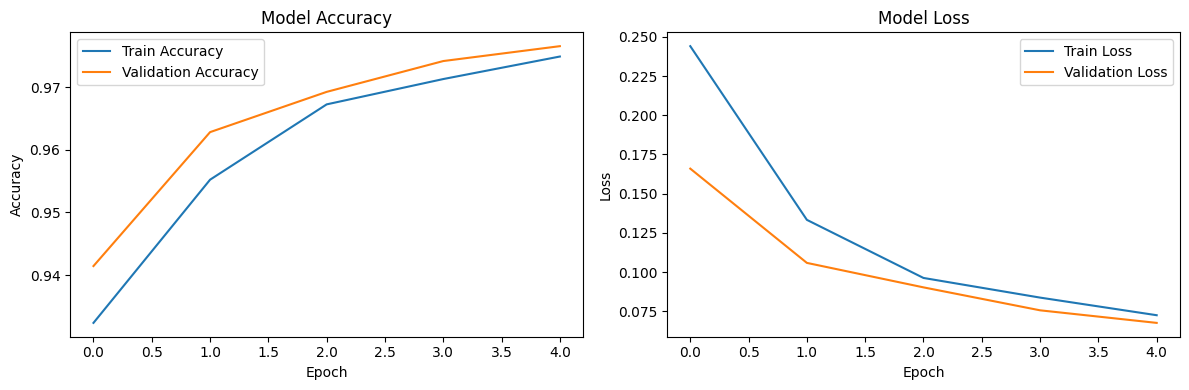

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history of accuracy and loss
plot_history(history)

**Note: Due to time and resource limits, the Bidirectional RNN was trained only for 5 epochs, which influenced the final character accuracy on the test set.**

# Evaluation

In [ ]:
def predict(line, model):
    X, _ = map_data([line])
    predictions = model.predict(X).squeeze()
    predictions = predictions[1:]

    output = ''
    for char, prediction in zip(remove_diacritics(line), predictions):
        output += char

        if char not in ARABIC_LETTERS_LIST:
            continue

        if '<' in REV_CLASSES_MAPPING[np.argmax(prediction)]:
            continue

        output += REV_CLASSES_MAPPING[np.argmax(prediction)]

    return output

In [ ]:
print(predict('مرحبا كيف الحال يا صديقي العزيز', model))

1/1 [==============================] - 4s 4s/step
مَرَحَبًا كَيْفَ الْحَالِ يَا صَدَيْقَي الْعَّزْيْزِ


In [ ]:
with open(DATASET_PATH + '/test.txt', 'r') as file:
    lines = file.readlines()

In [ ]:
results = list()
for idx, line in enumerate(lines):
    line = remove_diacritics(line.strip())
    x = predict(line, model)
    results.append(x)

1/1 [==============================] - 0s 110ms/step


In [ ]:
with open('outputs.txt', 'w') as file:
    file.write('\n'.join(results))

In [ ]:
# Calculate character-level accuracy for the test set
correct = 0
total = 0

for original, predicted in zip(lines, results):
    original = original.strip()
    predicted = predicted.strip()


    min_length = min(len(original), len(predicted))
    original = original[:min_length]
    predicted = predicted[:min_length]


    for o_char, p_char in zip(original, predicted):
        if o_char == p_char:
            correct += 1
        total += 1

# Calculate accuracy
char_accuracy = correct / total if total > 0 else 0
print(f'Character-Level Accuracy on Test Set: {char_accuracy:.2%}')

Character-Level Accuracy on Test Set: 18.15%


# **4- Transformers based model using seq2seq**

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


def map_data(data_raw):
    X = []
    Y = []

    for line in data_raw:
        x = [CHARACTERS_MAPPING['<SOS>']]
        y = [CLASSES_MAPPING['<SOS>']]

        for idx, char in enumerate(line):
            if char in DIACRITICS_LIST:
                continue

            x.append(CHARACTERS_MAPPING.get(char, CHARACTERS_MAPPING['<PAD>']))  # Use <PAD> if char is not found

            if char not in ARABIC_LETTERS_LIST:
                y.append(CLASSES_MAPPING[''])
            else:
                char_diac = ''
                if idx + 1 < len(line) and line[idx + 1] in DIACRITICS_LIST:
                    char_diac = line[idx + 1]
                    if idx + 2 < len(line) and line[idx + 2] in DIACRITICS_LIST and char_diac + line[idx + 2] in CLASSES_MAPPING:
                        char_diac += line[idx + 2]
                    elif idx + 2 < len(line) and line[idx + 2] in DIACRITICS_LIST and line[idx + 2] + char_diac in CLASSES_MAPPING:
                        char_diac = line[idx + 2] + char_diac
                y.append(CLASSES_MAPPING[char_diac])

        assert(len(x) == len(y))

        x.append(CHARACTERS_MAPPING['<EOS>'])
        y.append(CLASSES_MAPPING['<EOS>'])

        y = to_one_hot(y, len(CLASSES_MAPPING))

        X.append(x)
        Y.append(y)

    # Pad sequences to ensure uniform length
    X = pad_sequences(X, padding='post', value=CHARACTERS_MAPPING['<PAD>'])
    Y = pad_sequences(Y, padding='post', value=to_one_hot([CLASSES_MAPPING['<PAD>']], len(CLASSES_MAPPING))[0])

    return np.asarray(X), np.asarray(Y)

In [ ]:
class TransformerDiacritizer(keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input=1000, rate=0.1):
        super(TransformerDiacritizer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.final_layer = layers.Dense(target_vocab_size, activation='softmax')
        self.target_vocab_size = target_vocab_size

    def create_padding_mask(self, inp):
        padding_mask = tf.cast(tf.equal(inp, 0), tf.float32)
        return padding_mask[:, tf.newaxis, tf.newaxis, :]

    def call(self, inp, training=False):
        enc_padding_mask = self.create_padding_mask(inp)
        enc_output = self.encoder(x=inp, training=training, mask=enc_padding_mask)
        final_output = self.final_layer(enc_output)
        return final_output

# Prepare the target data
def prepare_target_data(target_data, num_classes):
    """Convert target data to one-hot encoded format"""
    # Reshape target data to (batch_size, seq_length, num_classes)
    target_shape = tf.shape(target_data)
    target_one_hot = tf.one_hot(target_data, depth=num_classes)
    return target_one_hot

# Initialize the model
model = TransformerDiacritizer(
    num_layers=4,
    d_model=128,
    num_heads=8,
    dff=512,
    input_vocab_size=len(CHARACTERS_MAPPING),
    target_vocab_size=len(CLASSES_MAPPING),
    pe_input=max_len,
    rate=0.1
)

# Convert target data to one-hot format
train_output_one_hot = prepare_target_data(train_output_padded, len(CLASSES_MAPPING))
val_output_one_hot = prepare_target_data(val_output_padded, len(CLASSES_MAPPING))

# Custom loss function that handles the padding
def masked_loss(y_true, y_pred):
    # Create mask to ignore padding tokens
    mask = tf.math.logical_not(tf.math.equal(tf.reduce_sum(y_true, axis=-1), 0))
    loss_ = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

class CharacterAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='char_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_class = tf.argmax(y_true, axis=-1)
        predictions = tf.argmax(y_pred, axis=-1)
        mask = tf.reduce_any(tf.not_equal(y_true, 0), axis=-1)
        correct = tf.equal(predictions, y_true_class)
        correct = tf.logical_and(correct, mask)

        # Cast mask to float32 before using it in reduce_sum
        self.total.assign_add(tf.reduce_sum(tf.cast(mask, tf.float32)))
        self.count.assign_add(tf.reduce_sum(tf.cast(correct, tf.float32)))

    def result(self):
        return self.count / self.total

class DiacritizationErrorRate(tf.keras.metrics.Metric):
    def __init__(self, name='DER', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total_chars = self.add_weight(name='total_chars', initializer='zeros')
        self.errors = self.add_weight(name='errors', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_class = tf.argmax(y_true, axis=-1)
        predictions = tf.argmax(y_pred, axis=-1)
        mask = tf.reduce_any(tf.not_equal(y_true, 0), axis=-1)
        errors = tf.not_equal(predictions, y_true_class)
        errors = tf.logical_and(errors, mask)

        # Cast mask and errors to float32 before using them in reduce_sum
        self.total_chars.assign_add(tf.reduce_sum(tf.cast(mask, tf.float32)))
        self.errors.assign_add(tf.reduce_sum(tf.cast(errors, tf.float32)))

    def result(self):
        return self.errors / self.total_chars

# Compile the model with custom loss and metrics
optimizer = Adam(learning_rate=0.01, weight_decay=0.0005)

model.compile(
    optimizer=optimizer,
    loss=masked_loss,
    metrics=[
        CharacterAccuracy(),
        DiacritizationErrorRate()
    ]
)

# Train the model with the one-hot encoded targets
history = model.fit(
    train_input_padded,
    train_output_one_hot,
    epochs=10,
    batch_size=64,
    validation_data=(val_input_padded, val_output_one_hot),
    callbacks=[checkpoint_callback, history_callback]
)

Epoch 1/10
462/462 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - DER: 0.1896 - char_accuracy: 0.8104 - loss: 0.8495
Epoch 1: val_loss improved from inf to 1.03521, saving model to best_diacritizer.weights.h5

Epoch 1 Results:
Train Loss: 0.7404
Train Character Accuracy: 0.8220
Train DER: 0.1780
Validation Loss: 1.0352
Validation Character Accuracy: 0.8233
Validation DER: 0.1767
462/462 ━━━━━━━━━━━━━━━━━━━━ 918s 2s/step - DER: 0.1896 - char_accuracy: 0.8104 - loss: 0.8493 - val_DER: 0.1767 - val_char_accuracy: 0.8233 - val_loss: 1.0352
Epoch 2/10
462/462 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - DER: 0.1771 - char_accuracy: 0.8229 - loss: 0.6849
Epoch 2: val_loss did not improve from 1.03521

Epoch 2 Results:
Train Loss: 0.6807
Train Character Accuracy: 0.8243
Train DER: 0.1757
Validation Loss: 1.1211
Validation Character Accuracy: 0.8233
Validation DER: 0.1767
462/462 ━━━━━━━━━━━━━━━━━━━━ 957s 2s/step - DER: 0.1771 - char_accuracy: 0.8229 - loss: 0.6849 - val_DER: 0.1767 - val_char_accuracy: 0.8233 - val_

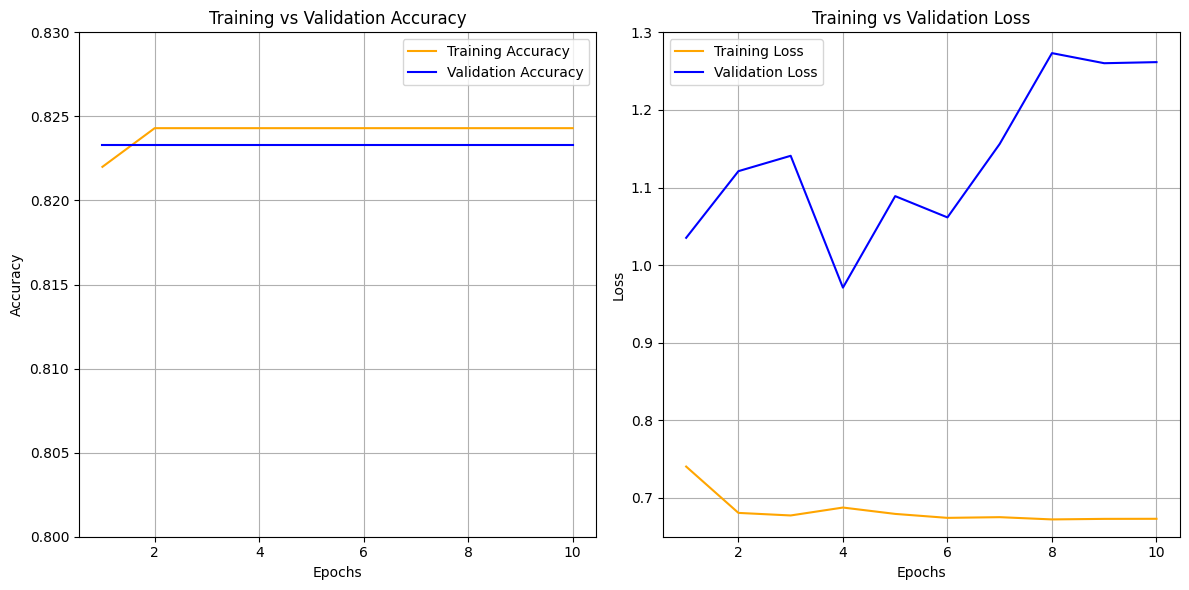

In [ ]:
import matplotlib.pyplot as plt

# Sample data (replace these values with your actual data if available)
epochs = range(1, 11)
train_accuracy = [0.8220, 0.8243, 0.8243, 0.8243, 0.8243, 0.8243, 0.8243, 0.8243, 0.8243, 0.8243]
val_accuracy = [0.8233, 0.8233, 0.8233, 0.8233, 0.8233, 0.8233, 0.8233, 0.8233, 0.8233, 0.8233]
train_loss = [0.7404, 0.6807, 0.6774, 0.6876, 0.6794, 0.6743, 0.6752, 0.6723, 0.6730, 0.6731]
val_loss = [1.0352, 1.1211, 1.1409, 0.9710, 1.0889, 1.0615, 1.1562, 1.2732, 1.2602, 1.2616]

# Plotting Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, color='orange', label='Training Accuracy')
plt.plot(epochs, val_accuracy, color='blue', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.80, 0.83)  # Adjust y-axis for better visualization
plt.legend()
plt.grid(True)

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, color='orange', label='Training Loss')
plt.plot(epochs, val_loss, color='blue', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.65, 1.3)  # Adjust y-axis for better visualization
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
results = model.evaluate(test_input_padded, y_true_one_hot)
test_loss, test_accuracy, other_metric = results  # Adjust based on the number of metrics
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Other Metric: {other_metric}")

472/472 ━━━━━━━━━━━━━━━━━━━━ 140s 296ms/step - DER: 0.1751 - char_accuracy: 0.8249 - loss: 1.2501
Test Loss: 1.2587379217147827, Test Accuracy: 0.8237132430076599, Other Metric: 0.17628677189350128


In [ ]:
print(predictions)

[[[9.9589378e-01 1.6609740e-03 1.3224152e-05 ... 2.3180206e-10
   6.0766663e-11 6.9067096e-10]
  [9.9589378e-01 1.6609740e-03 1.3224178e-05 ... 2.3180206e-10
   6.0766663e-11 6.9067096e-10]
  [9.9589378e-01 1.6609748e-03 1.3224178e-05 ... 2.3180206e-10
   6.0766780e-11 6.9067230e-10]
  ...
  [9.9589372e-01 1.6609739e-03 1.3224177e-05 ... 2.3180205e-10
   6.0766656e-11 6.9067224e-10]
  [9.9589372e-01 1.6609739e-03 1.3224177e-05 ... 2.3180205e-10
   6.0766656e-11 6.9067224e-10]
  [9.9589372e-01 1.6609739e-03 1.3224164e-05 ... 2.3180205e-10
   6.0766663e-11 6.9067224e-10]]]


In [ ]:
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
print("Predicted classes:", predicted_classes)


Predicted classes: [[ 0 91 43 ...  4  4  4]
 [ 0  6  6 ... 27 17  0]
 [ 0 39  0 ...  9 40 39]
 ...
 [ 0  1  1 ...  1 24  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  5  5 ... 25 16 30]]


In [ ]:
predictions = model.predict(input_data)
print(f"Predictions Shape: {predictions.shape}")
print(f"Predictions: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predictions Shape: (1, 100, 19)
Predictions: [[[9.9589378e-01 1.6609740e-03 1.3224152e-05 ... 2.3180206e-10
   6.0766663e-11 6.9067096e-10]
  [9.9589378e-01 1.6609740e-03 1.3224178e-05 ... 2.3180206e-10
   6.0766663e-11 6.9067096e-10]
  [9.9589378e-01 1.6609748e-03 1.3224178e-05 ... 2.3180206e-10
   6.0766780e-11 6.9067230e-10]
  ...
  [9.9589372e-01 1.6609739e-03 1.3224177e-05 ... 2.3180205e-10
   6.0766656e-11 6.9067224e-10]
  [9.9589372e-01 1.6609739e-03 1.3224177e-05 ... 2.3180205e-10
   6.0766656e-11 6.9067224e-10]
  [9.9589372e-01 1.6609739e-03 1.3224164e-05 ... 2.3180205e-10
   6.0766663e-11 6.9067224e-10]]]
